<a href="https://colab.research.google.com/github/stiwari-ds/data-science-competitions/blob/main/dphi/ds88/notebooks/01_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [93]:
import gc
import os
import time
import warnings

gc.enable()
warnings.filterwarnings(action='ignore')

import pandas as pd
import numpy as np

pd.set_option('precision', 4)
np.set_printoptions(precision=4)

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

SEED = 23
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)

In [94]:
data_url = 'https://raw.githubusercontent.com/stiwari-ds/data-science-competitions/main/dphi/ds88/data/'

train = pd.read_csv(data_url + 'raw/train.csv')
test = pd.read_csv(data_url + 'raw/test.csv')

# Data Overview

In [95]:
train.head()

,length,diameter,height,whole-weight,shucked-weight,viscera-weight,shell-weight,sex_F,sex_I,sex_M,rings
0,124,97,41,243.8,77.5,50.1,77.0,0,0,1,14
1,109,88,27,183.7,85.8,40.3,47.5,1,0,0,10
2,136,108,38,324.6,143.3,70.8,94.3,0,0,1,12
3,110,88,33,172.1,62.4,33.8,60.0,0,1,0,17
4,78,60,20,53.3,22.1,11.8,16.8,0,1,0,7


In [96]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3550 entries, 0 to 3549
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   length          3550 non-null   int64  
 1   diameter        3550 non-null   int64  
 2   height          3550 non-null   int64  
 3   whole-weight    3550 non-null   float64
 4   shucked-weight  3550 non-null   float64
 5   viscera-weight  3550 non-null   float64
 6   shell-weight    3550 non-null   float64
 7   sex_F           3550 non-null   int64  
 8   sex_I           3550 non-null   int64  
 9   sex_M           3550 non-null   int64  
 10  rings           3550 non-null   int64  
dtypes: float64(4), int64(7)
memory usage: 305.2 KB


In [97]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 627 entries, 0 to 626
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   length          627 non-null    int64  
 1   diameter        627 non-null    int64  
 2   height          627 non-null    int64  
 3   whole-weight    627 non-null    float64
 4   shucked-weight  627 non-null    float64
 5   viscera-weight  627 non-null    float64
 6   shell-weight    627 non-null    float64
 7   sex_F           627 non-null    int64  
 8   sex_I           627 non-null    int64  
 9   sex_M           627 non-null    int64  
dtypes: float64(4), int64(6)
memory usage: 49.1 KB


In [98]:
TARGET = 'rings'

# EDA

### Plotting utils

In [99]:
def plot_cont(feature):
    """Plot side-by-side kdeplots for train and test
    data distribution of continuous feature.
    """
    fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(20,5))
    plt.suptitle(f'Feature distribution: {feature}')
    sns.kdeplot(x=feature, data=train, ax=ax[0], cut=0)
    ax[0].set_title('Train data')
    sns.kdeplot(x=feature, data=test, ax=ax[1], cut=0)
    ax[1].set_title('Test data')
    plt.show()

In [100]:
def plot_cont_vs_target(feature):
    """Plot scatterplot with continuous feature on
    x-axis and Target on y-axis.
    """
    plt.figure(figsize=(12, 7))
    plt.suptitle(f'{feature} vs. {TARGET}')
    sns.scatterplot(x=feature, y=TARGET, data=train)
    plt.show()

In [101]:
def plot_target_vs_cat(feature):
    """Plot kdeplot for Target column split by
    feature categories.
    """
    plt.figure(figsize=(12, 5))
    plt.suptitle(f'{TARGET} vs. {feature}')
    sns.kdeplot(x=TARGET, data=train, hue=feature, cut=0)
    plt.show()

### length

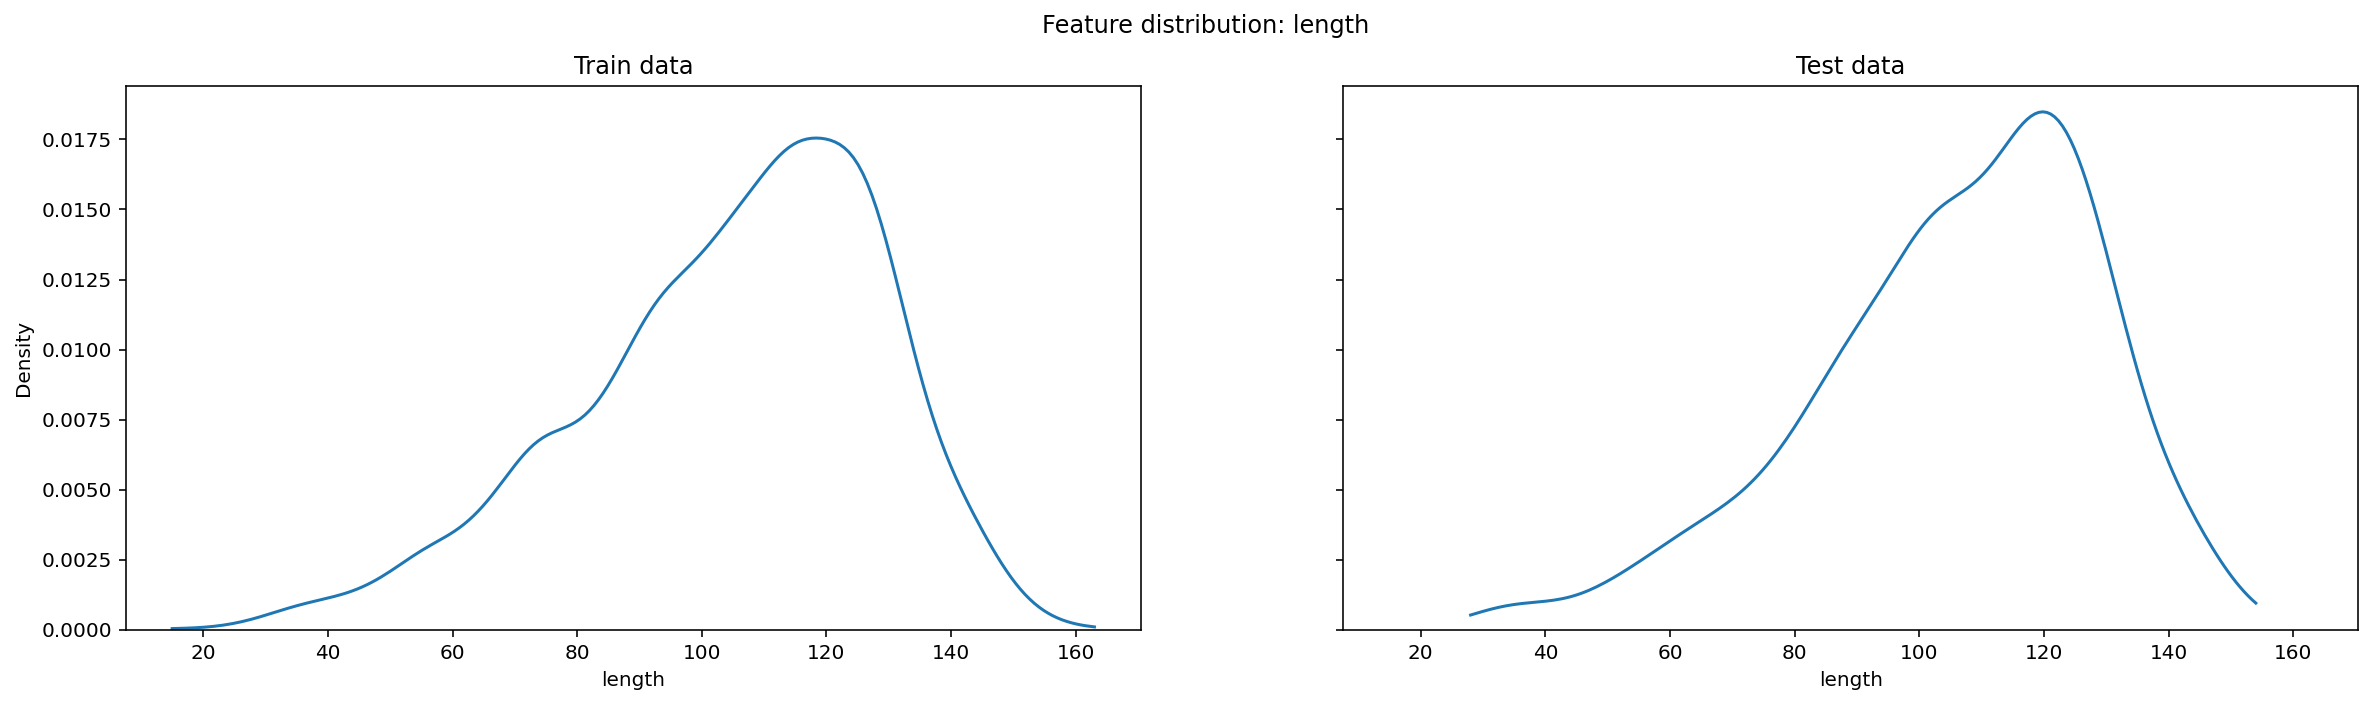

In [102]:
plot_cont('length')

In [103]:
test.length.min(), test.length.max()

(28, 154)

In [104]:
train.loc[train.length > 154]

,length,diameter,height,whole-weight,shucked-weight,viscera-weight,shell-weight,sex_F,sex_I,sex_M,rings
1273,155,126,50,555.9,269.7,152.0,115.6,0,0,1,12
1683,156,120,42,509.6,238.9,114.9,134.9,0,0,1,11
2435,163,130,50,451.0,178.1,84.0,159.5,1,0,0,14
2477,160,126,39,505.2,186.6,118.0,124.0,1,0,0,23
3291,156,126,43,531.4,297.6,99.7,117.2,1,0,0,11
3528,155,114,44,406.4,147.0,95.1,131.7,0,0,1,17


In [105]:
train.loc[train.length < 28]

,length,diameter,height,whole-weight,shucked-weight,viscera-weight,shell-weight,sex_F,sex_I,sex_M,rings
89,27,26,8,5.8,2.5,1.3,1.6,0,1,0,4
1211,26,20,6,2.6,0.9,0.6,0.8,0,1,0,3
1443,15,11,2,0.4,0.2,0.1,0.3,0,1,0,1
1561,26,19,7,2.1,1.0,1.3,0.7,0,1,0,4
2515,22,18,6,1.6,0.5,0.4,0.6,0,1,0,3


**Dropping outliers:**

In [106]:
train = train[(train.length > 25) & (train.length < 160)]

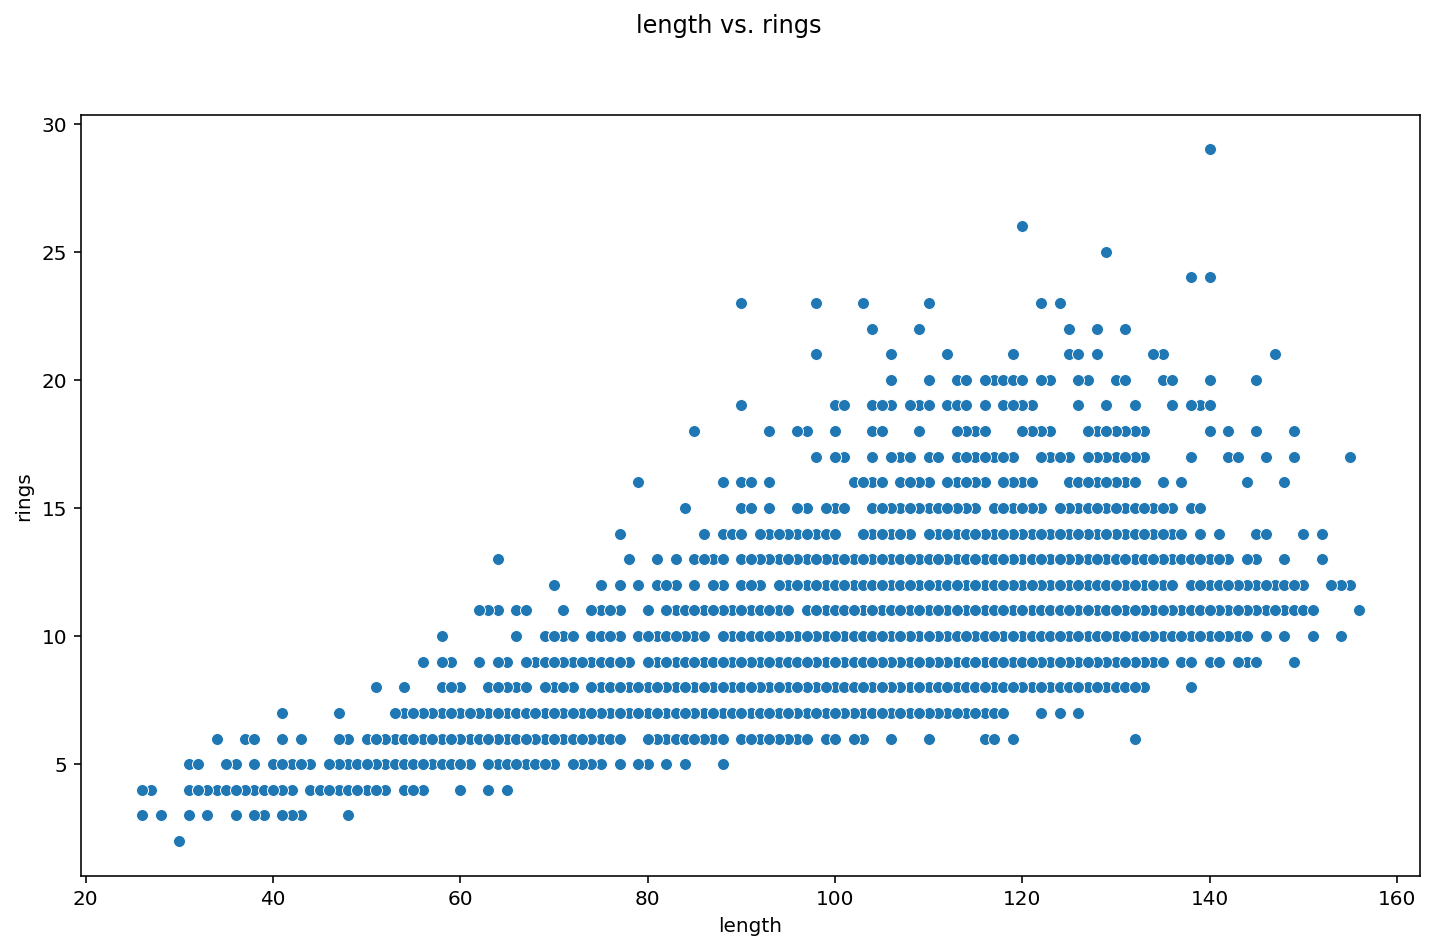

In [107]:
plot_cont_vs_target('length')

In [108]:
train[['length', TARGET]].corr()

,length,rings
length,1.0000,0.5571
rings,0.5571,1.0000


### diameter

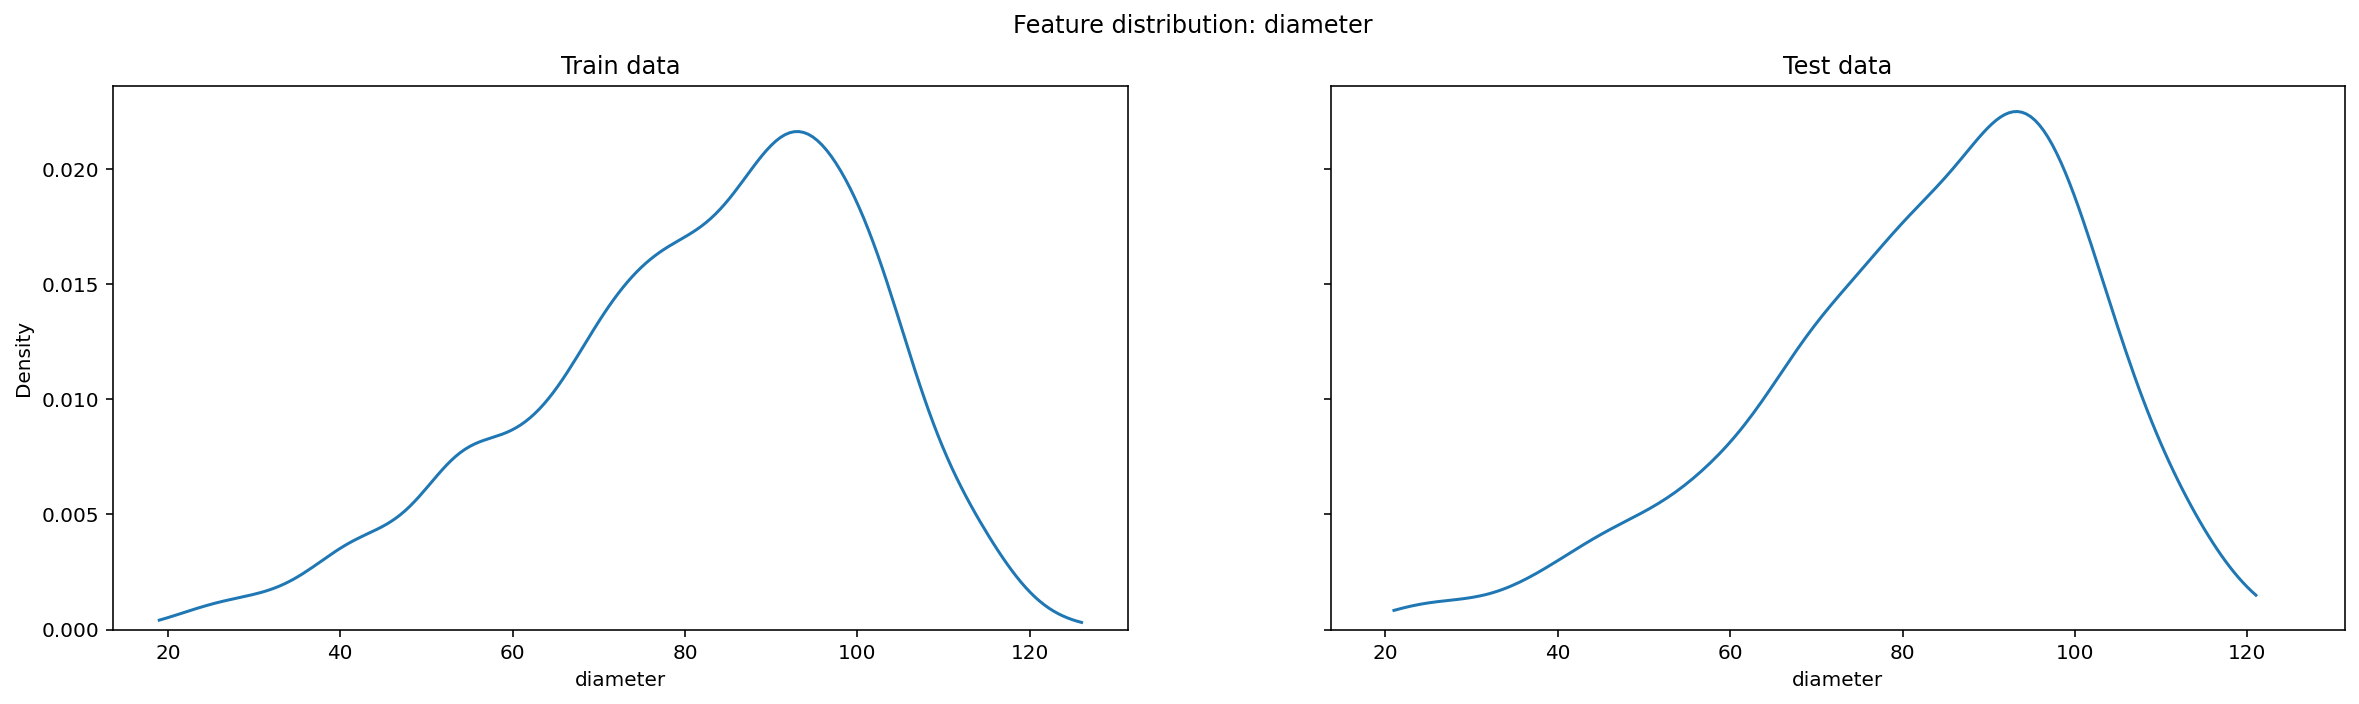

In [109]:
plot_cont('diameter')

In [110]:
test.diameter.min(), test.diameter.max()

(21, 121)

In [111]:
train.loc[train.diameter < 21]

,length,diameter,height,whole-weight,shucked-weight,viscera-weight,shell-weight,sex_F,sex_I,sex_M,rings
1211,26,20,6,2.6,0.9,0.6,0.8,0,1,0,3
1561,26,19,7,2.1,1.0,1.3,0.7,0,1,0,4
1749,30,20,5,3.0,0.9,0.8,1.0,0,1,0,2


In [112]:
train.loc[train.diameter > 121]

,length,diameter,height,whole-weight,shucked-weight,viscera-weight,shell-weight,sex_F,sex_I,sex_M,rings
133,150,123,41,452.7,164.2,84.6,145.2,1,0,0,12
1273,155,126,50,555.9,269.7,152.0,115.6,0,0,1,12
1362,154,124,39,503.1,223.1,128.3,128.4,0,0,1,12
1891,150,122,47,501.7,246.4,103.8,122.4,1,0,0,14
2376,151,125,42,501.0,239.3,102.6,135.7,1,0,0,11
3291,156,126,43,531.4,297.6,99.7,117.2,1,0,0,11


No significant outliers.

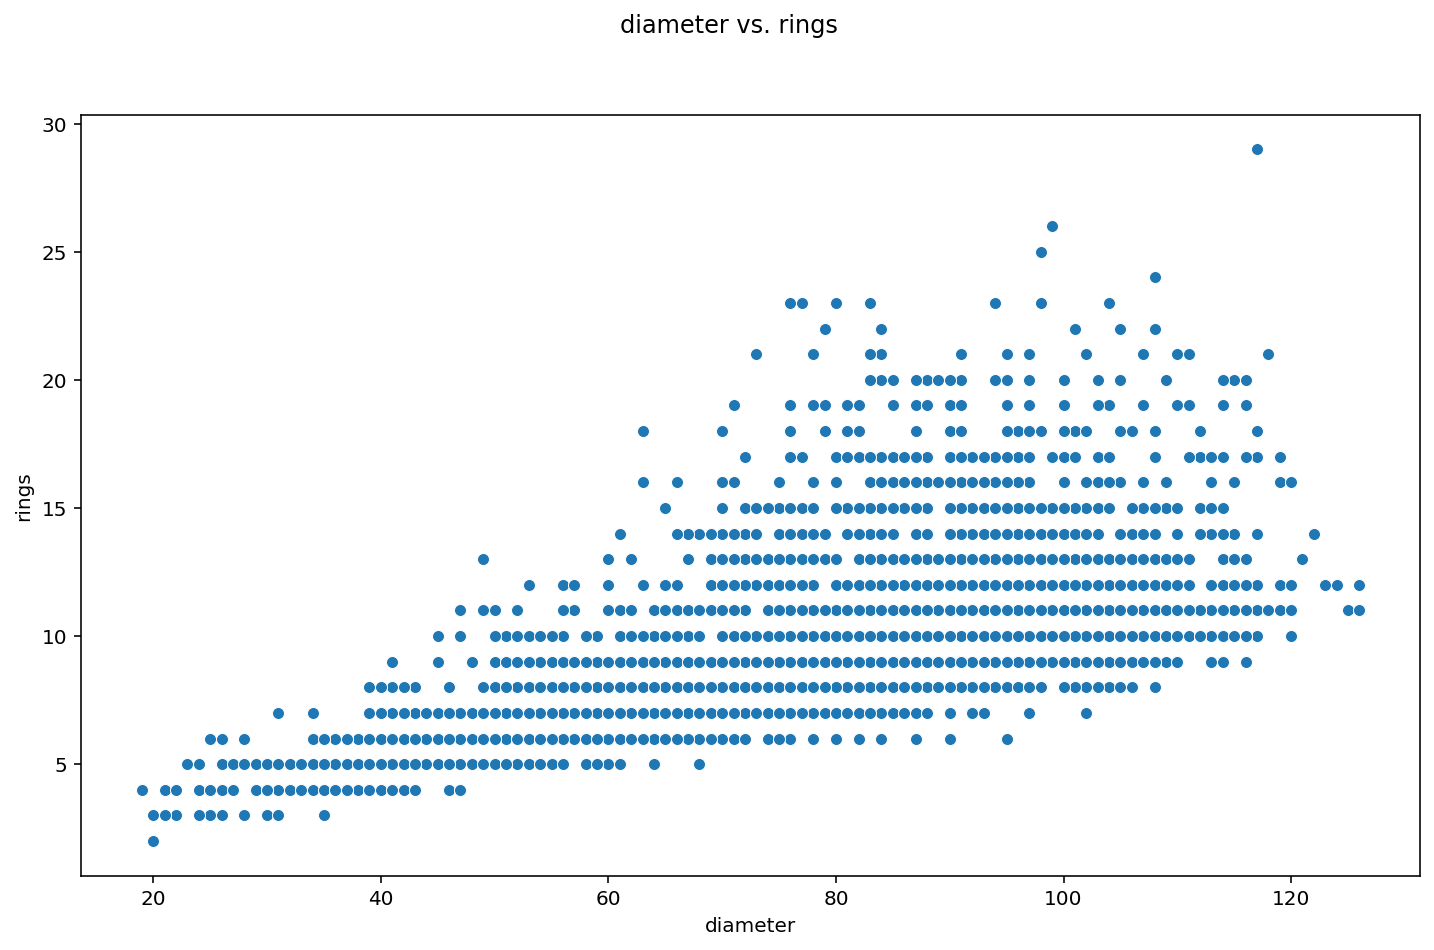

In [113]:
plot_cont_vs_target('diameter')

In [114]:
train[['length', 'diameter', TARGET]].corr()

,length,diameter,rings
length,1.0000,0.9866,0.5571
diameter,0.9866,1.0000,0.5750
rings,0.5571,0.5750,1.0000


**Length and diameter are highly correlated.**

### height

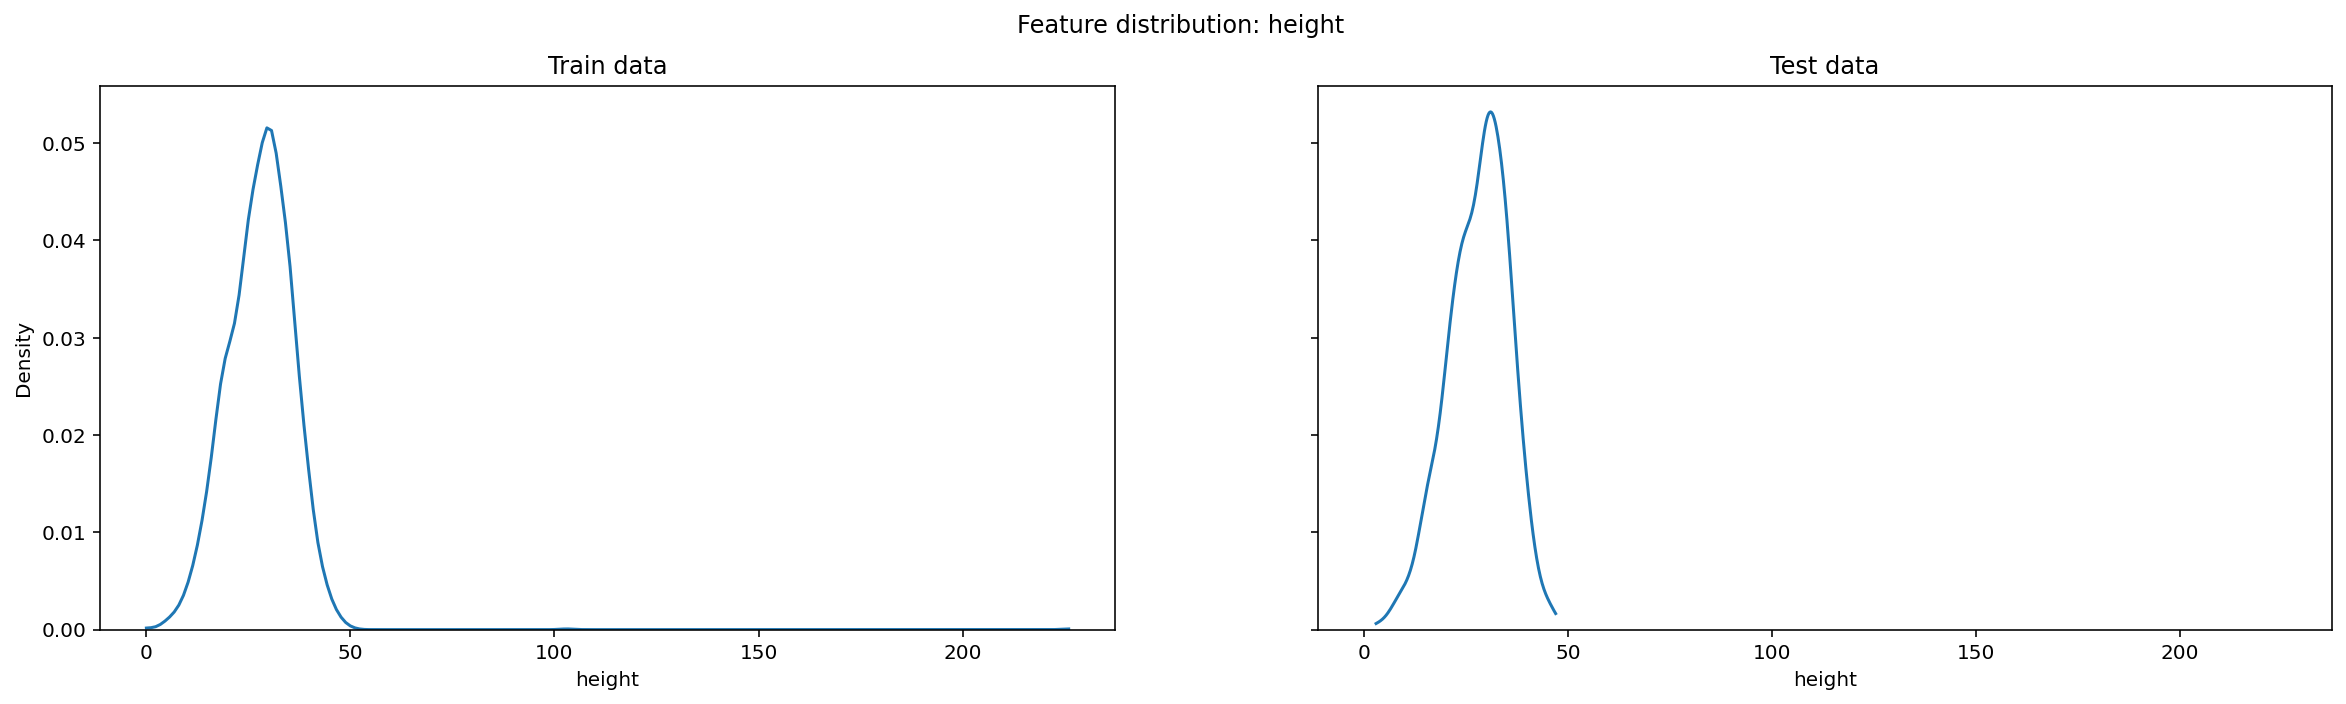

In [115]:
plot_cont('height')

***height* outliers in training data**

In [116]:
test.height.min(), test.height.max()

(3, 47)

In [117]:
train.loc[train.height > 47]

,length,diameter,height,whole-weight,shucked-weight,viscera-weight,shell-weight,sex_F,sex_I,sex_M,rings
911,91,71,226,118.8,66.4,23.2,26.7,1,0,0,8
1165,129,103,48,308.3,94.2,73.8,107.0,0,0,1,13
1273,155,126,50,555.9,269.7,152.0,115.6,0,0,1,12
1516,141,113,103,442.0,221.5,97.3,102.4,0,0,1,10
1734,145,115,48,442.0,270.2,82.6,100.3,0,0,1,13
1840,122,100,48,328.4,106.4,66.9,138.0,0,0,1,18
3015,119,94,50,256.6,92.4,49.5,89.0,1,0,0,14
3524,143,113,48,439.9,144.9,93.0,177.0,1,0,0,17


In [118]:
train.loc[train.height < 5]

,length,diameter,height,whole-weight,shucked-weight,viscera-weight,shell-weight,sex_F,sex_I,sex_M,rings
488,33,22,4,3.8,1.3,0.5,1.0,0,1,0,4
575,86,68,0,85.6,41.3,17.2,23.0,0,1,0,8
946,127,99,3,231.3,102.3,61.6,57.7,1,0,0,9
1863,32,24,4,3.6,1.5,0.9,1.0,0,1,0,4
3410,63,46,0,26.8,11.5,5.7,70.1,0,1,0,6


**Dropping outliers:**

In [119]:
train = train[(train.height > 0) & (train.height < 51)]

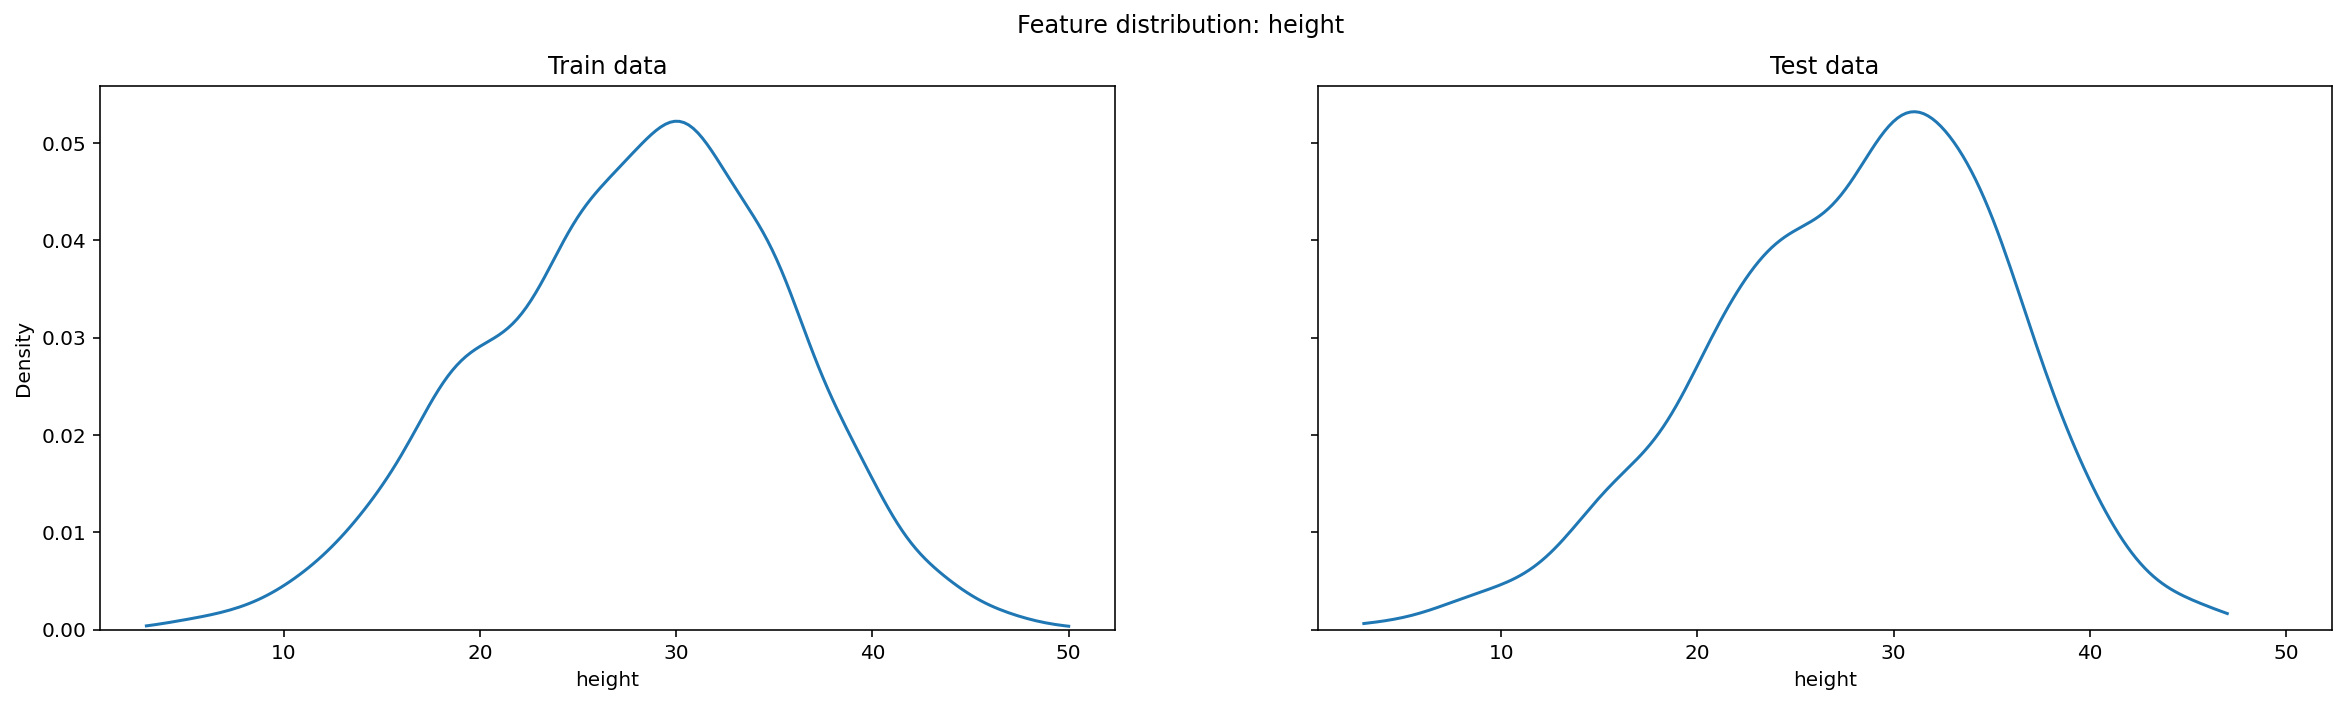

In [120]:
plot_cont('height')

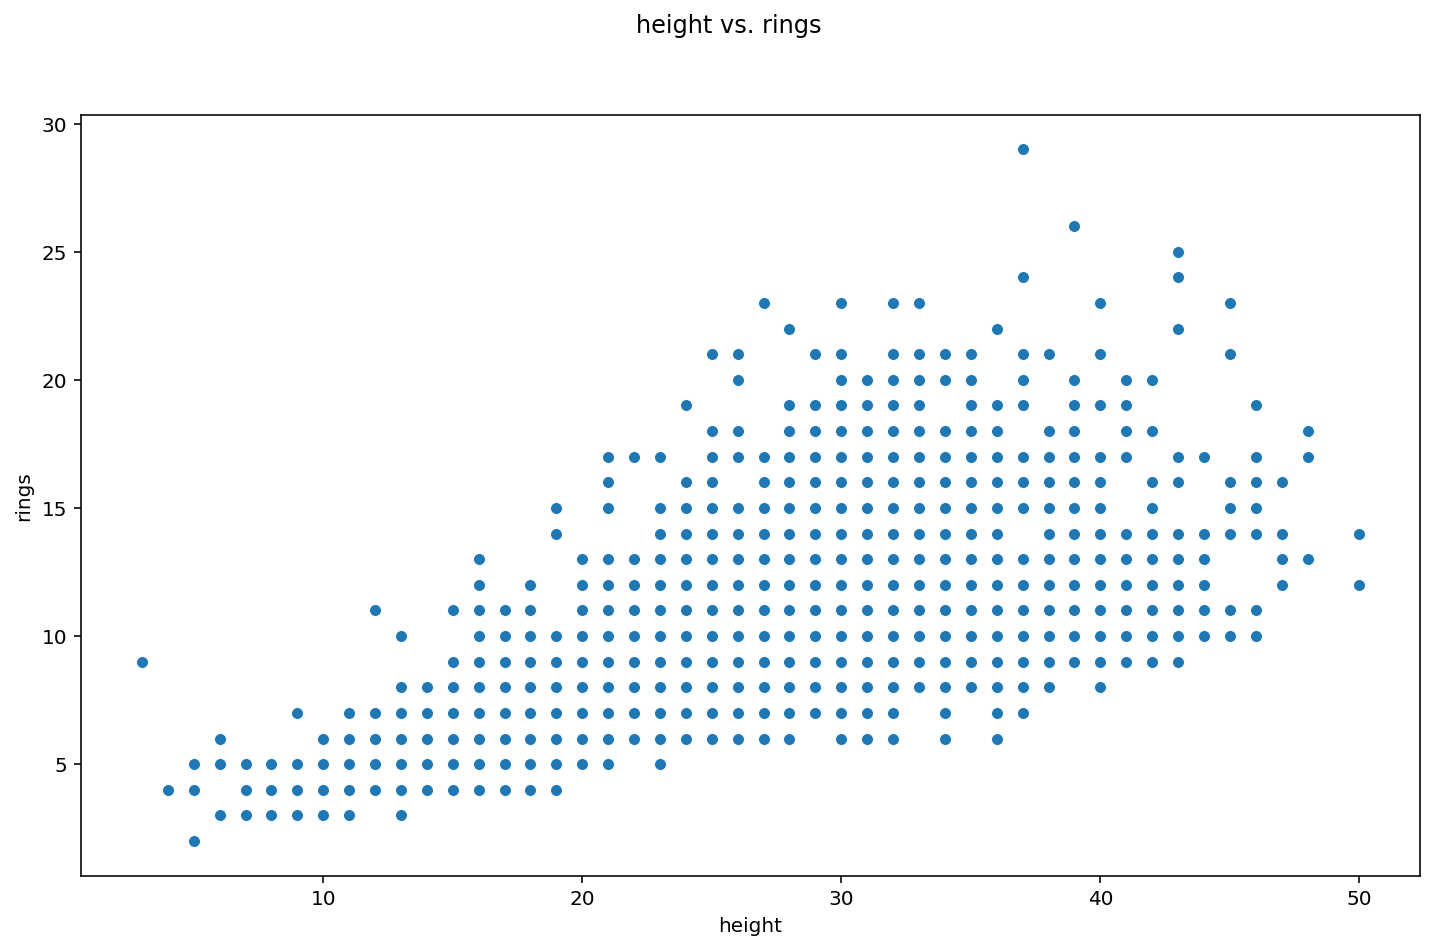

In [121]:
plot_cont_vs_target('height')

In [122]:
train[['length', 'height', TARGET]].corr()

,length,height,rings
length,1.0000,0.8994,0.5569
height,0.8994,1.0000,0.6115
rings,0.5569,0.6115,1.0000


Again, high correlation between length and height, but not as extreme as that with diameter.

### whole-weight

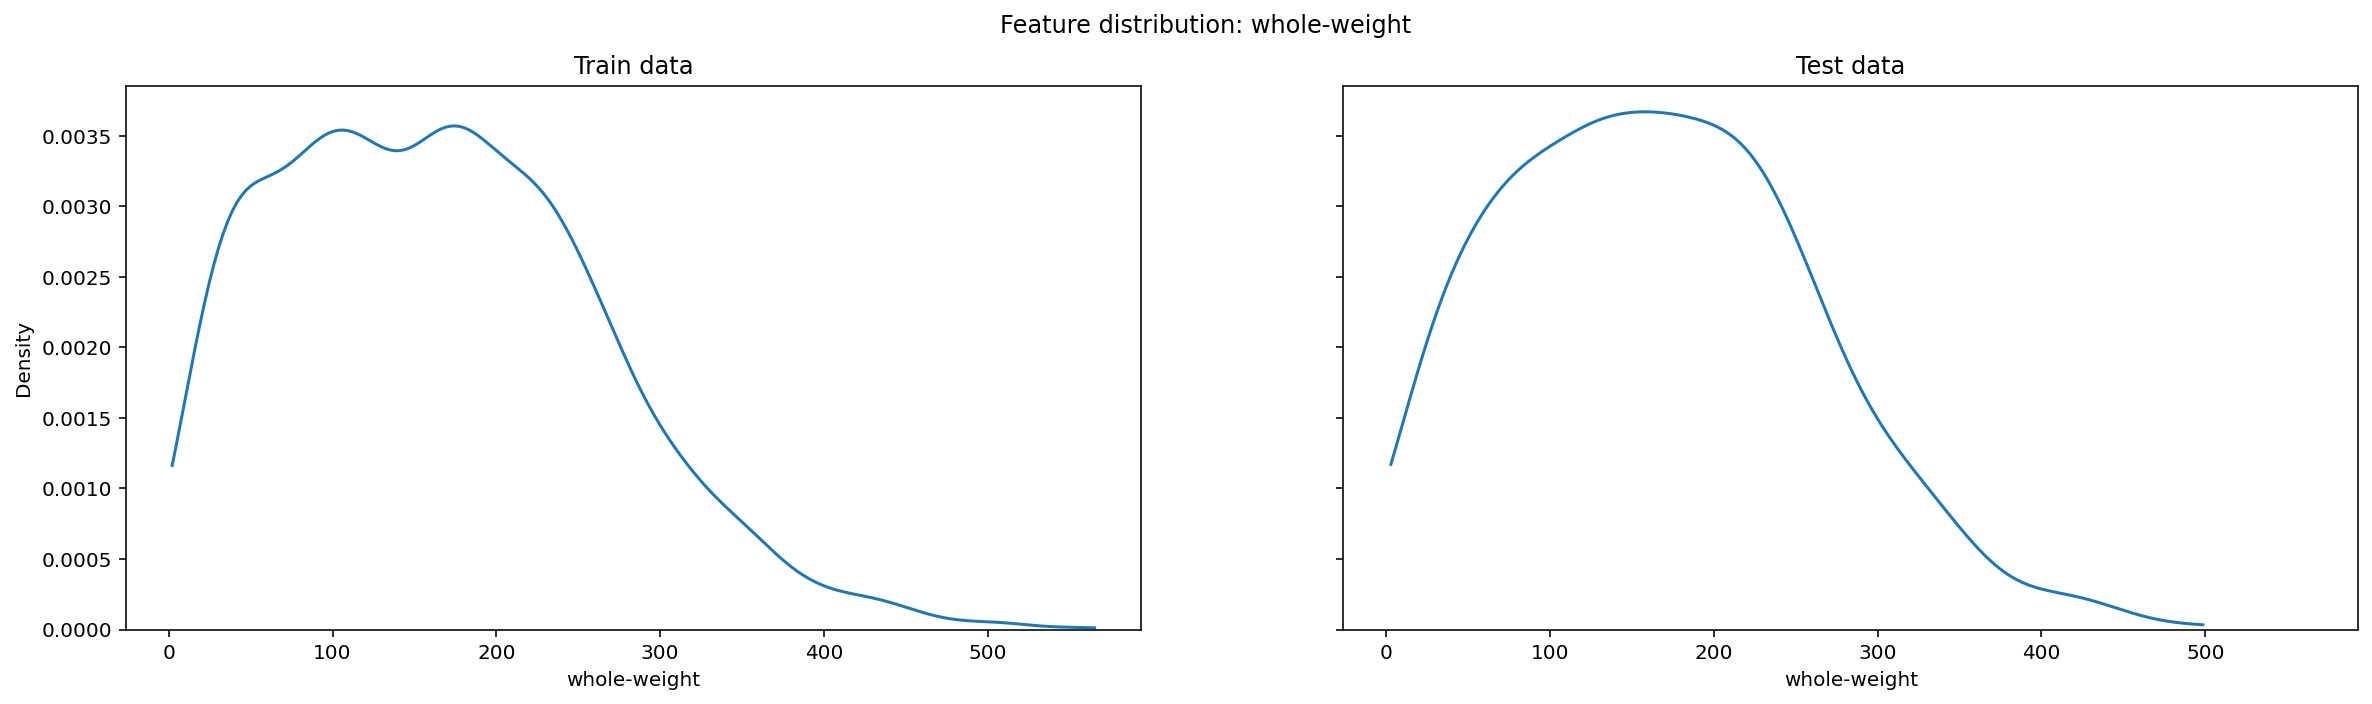

In [123]:
plot_cont('whole-weight')

In [124]:
test['whole-weight'].min(), test['whole-weight'].max()

(2.9, 498.5)

In [125]:
train.loc[train['whole-weight'] > 500]

,length,diameter,height,whole-weight,shucked-weight,viscera-weight,shell-weight,sex_F,sex_I,sex_M,rings
684,147,120,44,511.0,226.7,88.0,120.0,1,0,0,11
1273,155,126,50,555.9,269.7,152.0,115.6,0,0,1,12
1362,154,124,39,503.1,223.1,128.3,128.4,0,0,1,12
1683,156,120,42,509.6,238.9,114.9,134.9,0,0,1,11
1891,150,122,47,501.7,246.4,103.8,122.4,1,0,0,14
2106,146,119,46,565.1,229.3,83.8,179.4,0,0,1,17
2268,145,114,38,510.0,214.1,96.6,145.0,0,0,1,14
2376,151,125,42,501.0,239.3,102.6,135.7,1,0,0,11
3291,156,126,43,531.4,297.6,99.7,117.2,1,0,0,11


**Dropping outliers:**

In [126]:
train = train[train['whole-weight'] < 520]

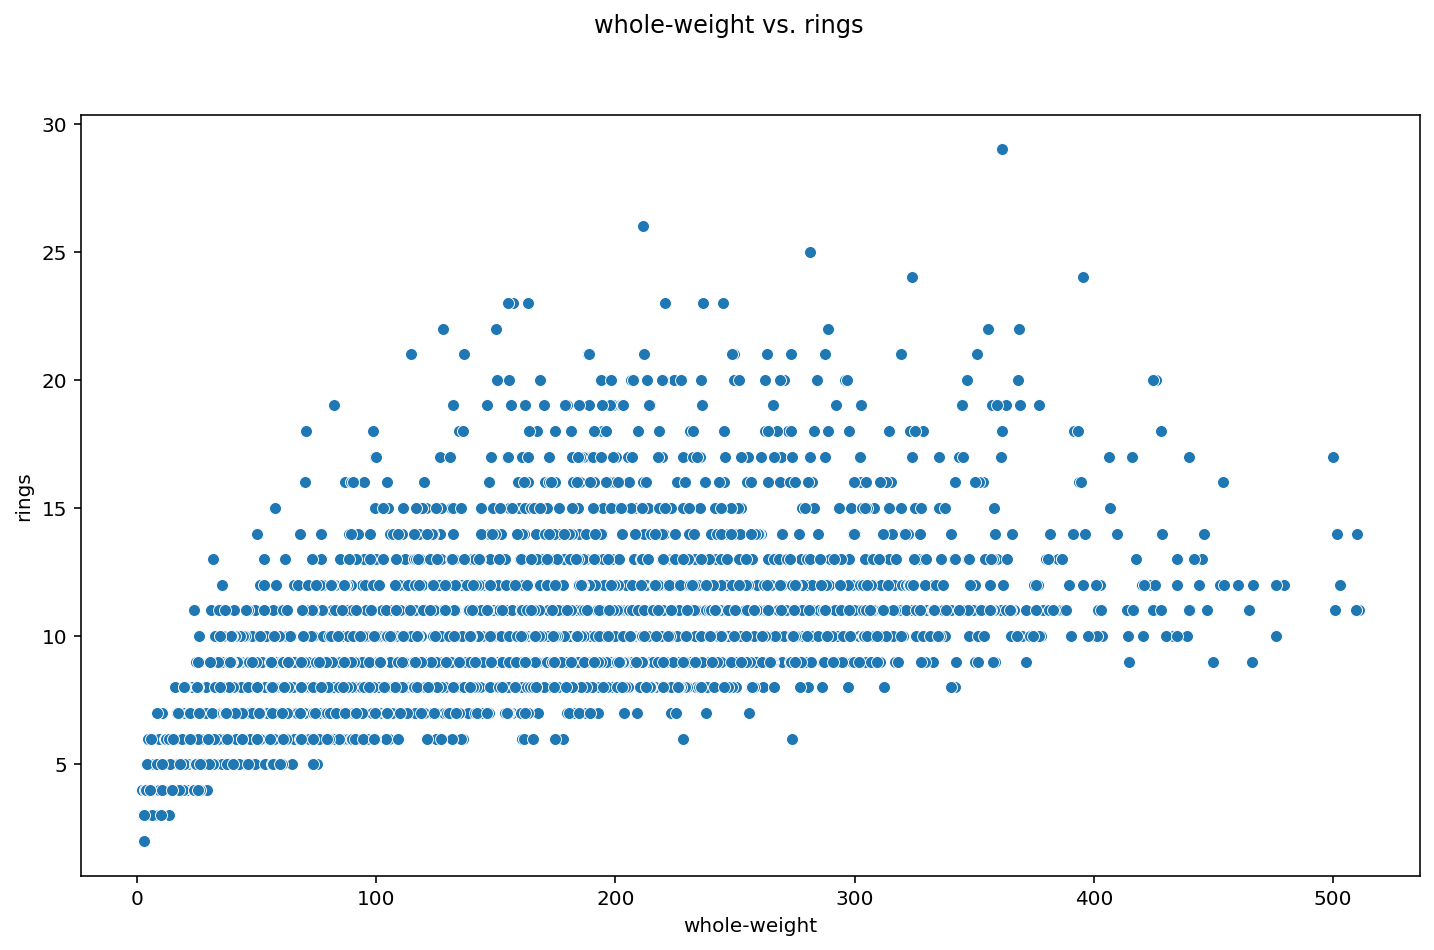

In [127]:
plot_cont_vs_target('whole-weight')

In [128]:
train[['length', 'whole-weight', TARGET]].corr()

,length,whole-weight,rings
length,1.0000,0.9271,0.5566
whole-weight,0.9271,1.0000,0.5421
rings,0.5566,0.5421,1.0000


**High correlation again.**

### shucked-weight

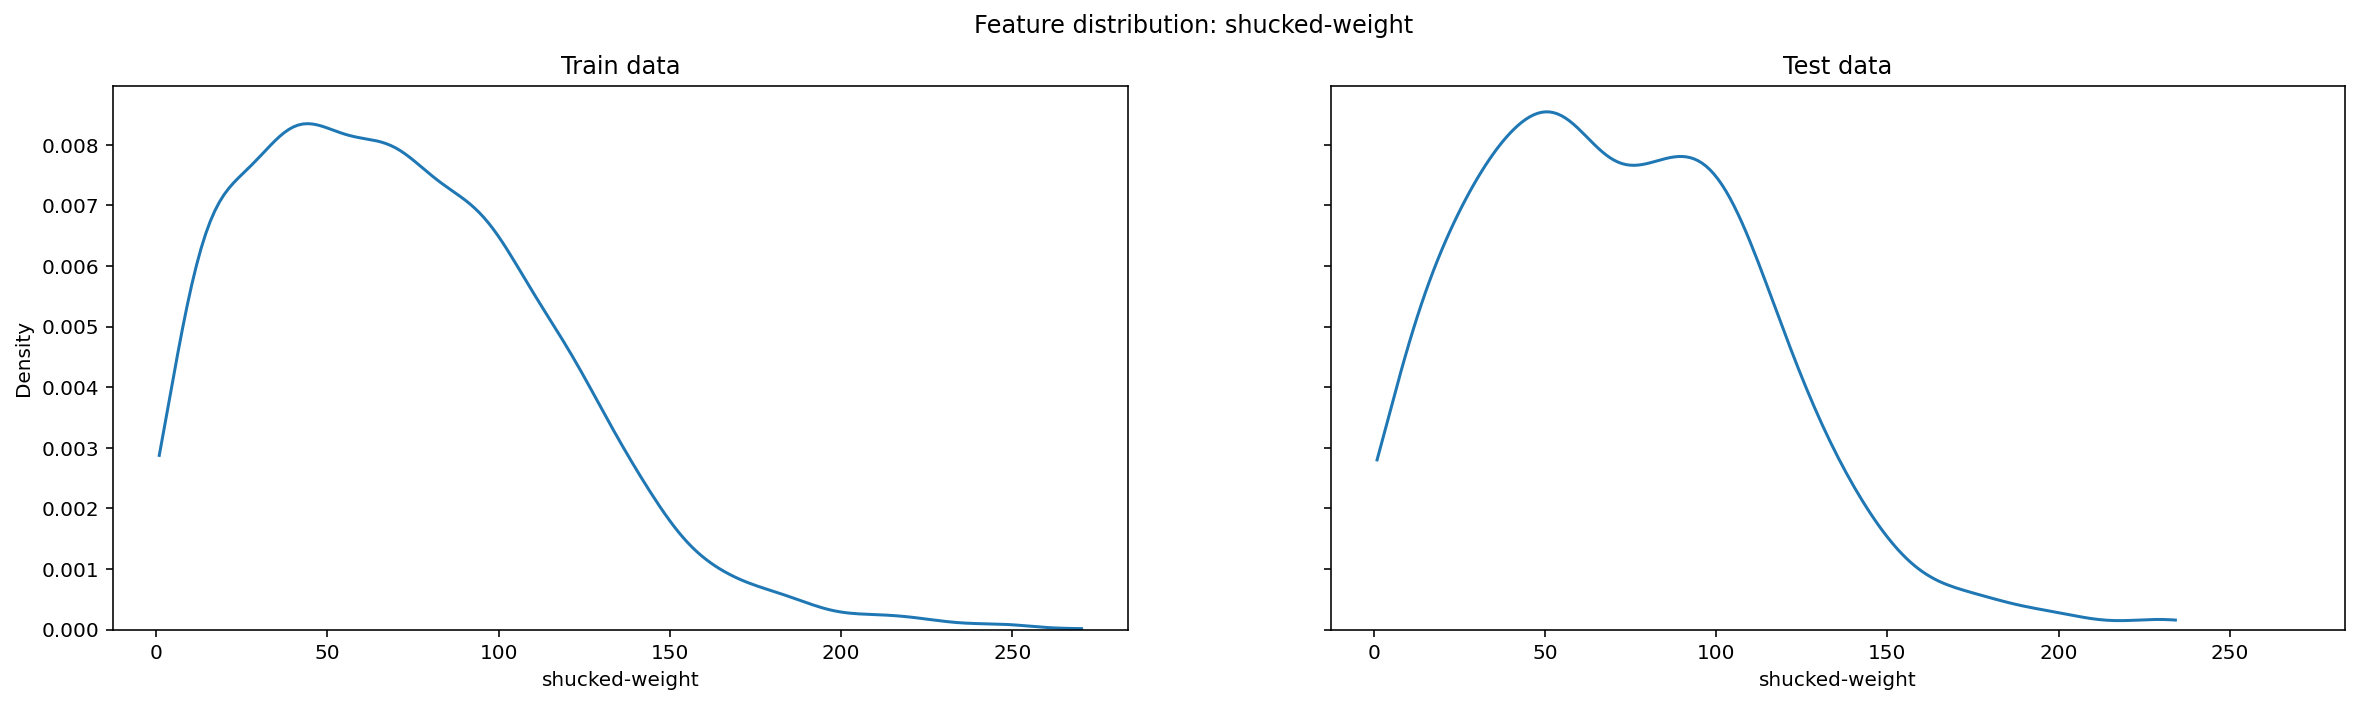

In [129]:
plot_cont('shucked-weight')

In [130]:
test['shucked-weight'].min(), test['shucked-weight'].max()

(1.0, 234.1)

In [131]:
train.loc[train['shucked-weight'] <= 1]

,length,diameter,height,whole-weight,shucked-weight,viscera-weight,shell-weight,sex_F,sex_I,sex_M,rings
1211,26,20,6,2.6,0.9,0.6,0.8,0,1,0,3
1459,31,21,10,3.5,1.0,0.7,1.0,0,1,0,4
1561,26,19,7,2.1,1.0,1.3,0.7,0,1,0,4
1749,30,20,5,3.0,0.9,0.8,1.0,0,1,0,2


In [132]:
train.loc[train['shucked-weight'] > 234]

,length,diameter,height,whole-weight,shucked-weight,viscera-weight,shell-weight,sex_F,sex_I,sex_M,rings
548,142,111,35,428.0,249.1,74.5,86.8,0,0,1,11
1552,146,117,45,446.1,247.9,84.4,112.6,0,0,1,14
1683,156,120,42,509.6,238.9,114.9,134.9,0,0,1,11
1734,145,115,48,442.0,270.2,82.6,100.3,0,0,1,13
1891,150,122,47,501.7,246.4,103.8,122.4,1,0,0,14
2269,147,111,44,466.6,247.9,72.9,123.9,0,0,1,12
2376,151,125,42,501.0,239.3,102.6,135.7,1,0,0,11
2437,145,114,38,466.1,250.6,108.2,104.0,0,0,1,9


**Dropping outliers:**

In [133]:
train = train[train['shucked-weight'] < 251]

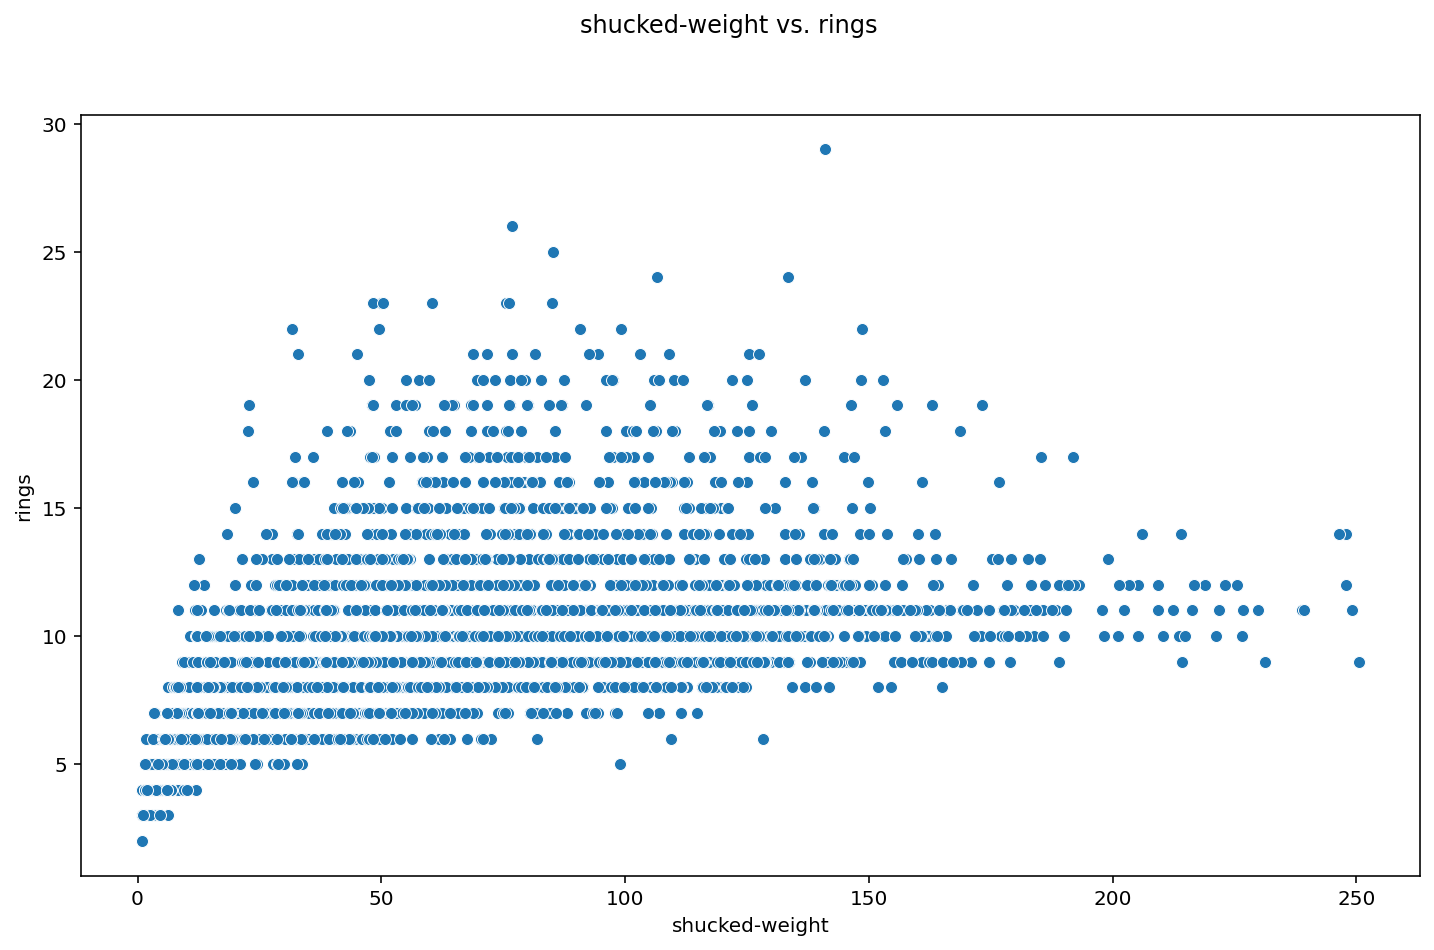

In [134]:
plot_cont_vs_target('shucked-weight')

In [135]:
train[['whole-weight', 'shucked-weight', TARGET]].corr()

,whole-weight,shucked-weight,rings
whole-weight,1.0000,0.9701,0.5420
shucked-weight,0.9701,1.0000,0.4241
rings,0.5420,0.4241,1.0000


**Very high correlation with whole-weight.**

### viscera-weight

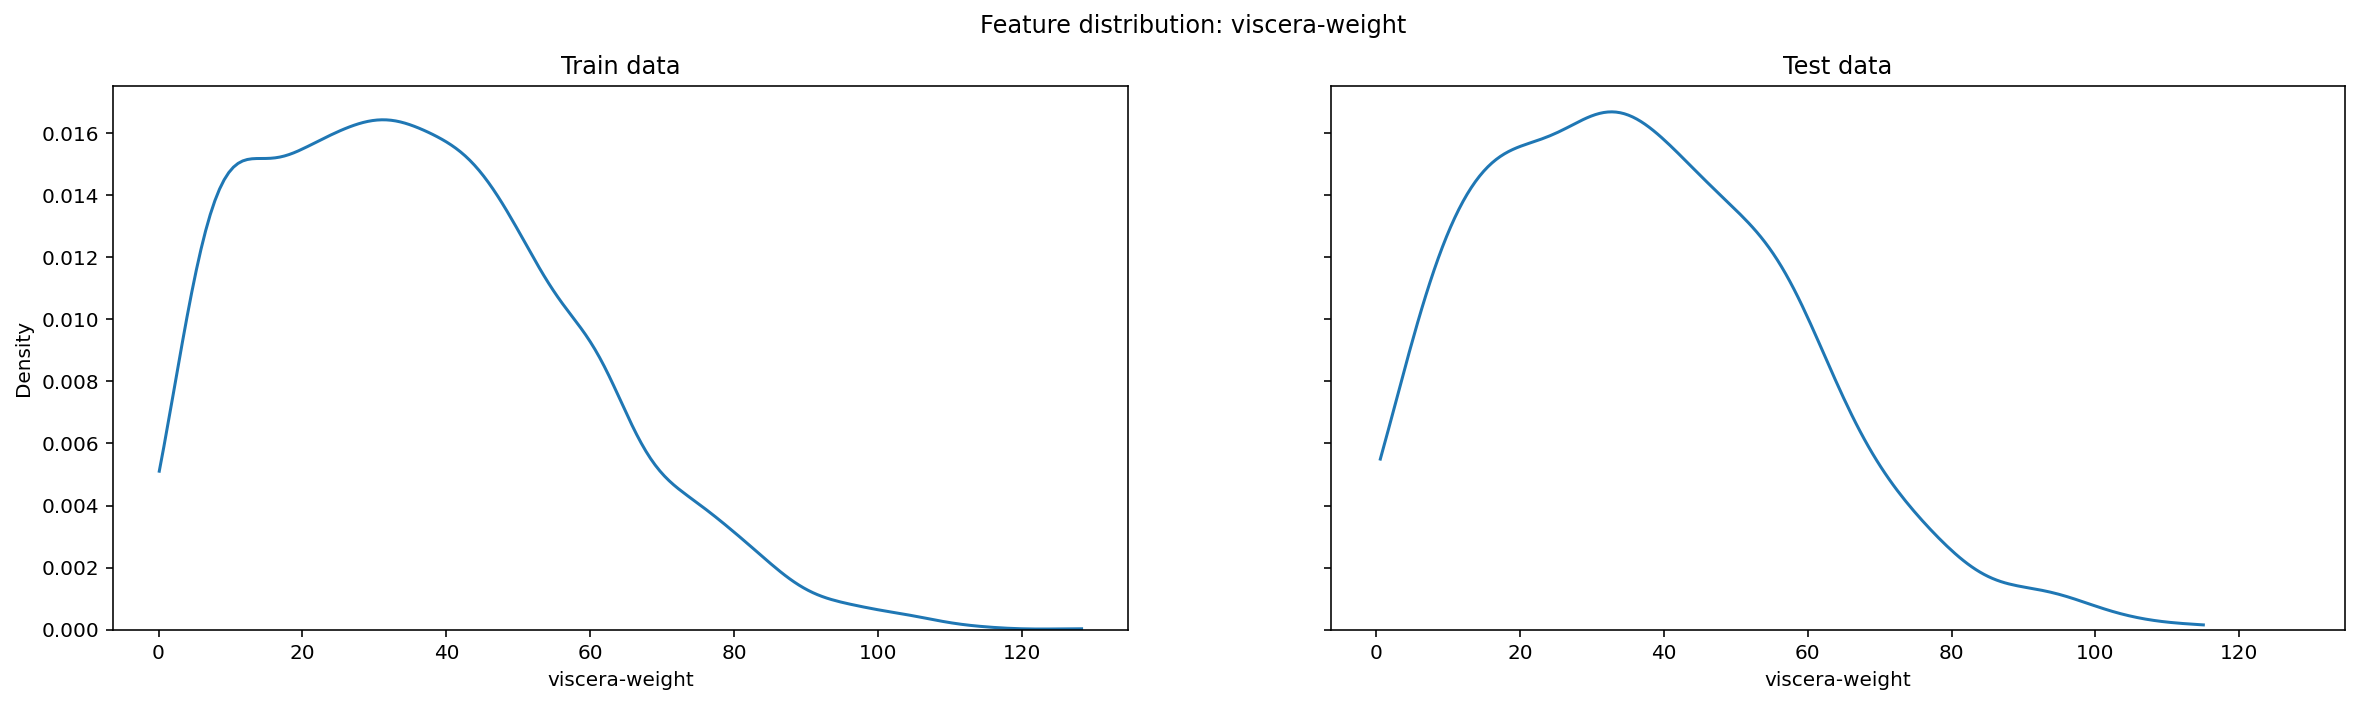

In [136]:
plot_cont('viscera-weight')

In [137]:
test['viscera-weight'].min(), test['viscera-weight'].max()

(0.6, 115.0)

In [138]:
train.loc[train['viscera-weight'] < 0.6]

,length,diameter,height,whole-weight,shucked-weight,viscera-weight,shell-weight,sex_F,sex_I,sex_M,rings
488,33,22,4,3.8,1.3,0.5,1.0,0,1,0,4
1714,48,37,12,13.1,5.9,0.1,4.0,0,1,0,4
3307,28,21,7,2.8,1.1,0.5,0.8,0,1,0,3


In [139]:
train.loc[train['viscera-weight'] > 115]

,length,diameter,height,whole-weight,shucked-weight,viscera-weight,shell-weight,sex_F,sex_I,sex_M,rings
1362,154,124,39,503.1,223.1,128.3,128.4,0,0,1,12


**Dropping outliers:**

In [140]:
train = train[(train['viscera-weight'] > 0.1) & (train['viscera-weight'] < 120)]

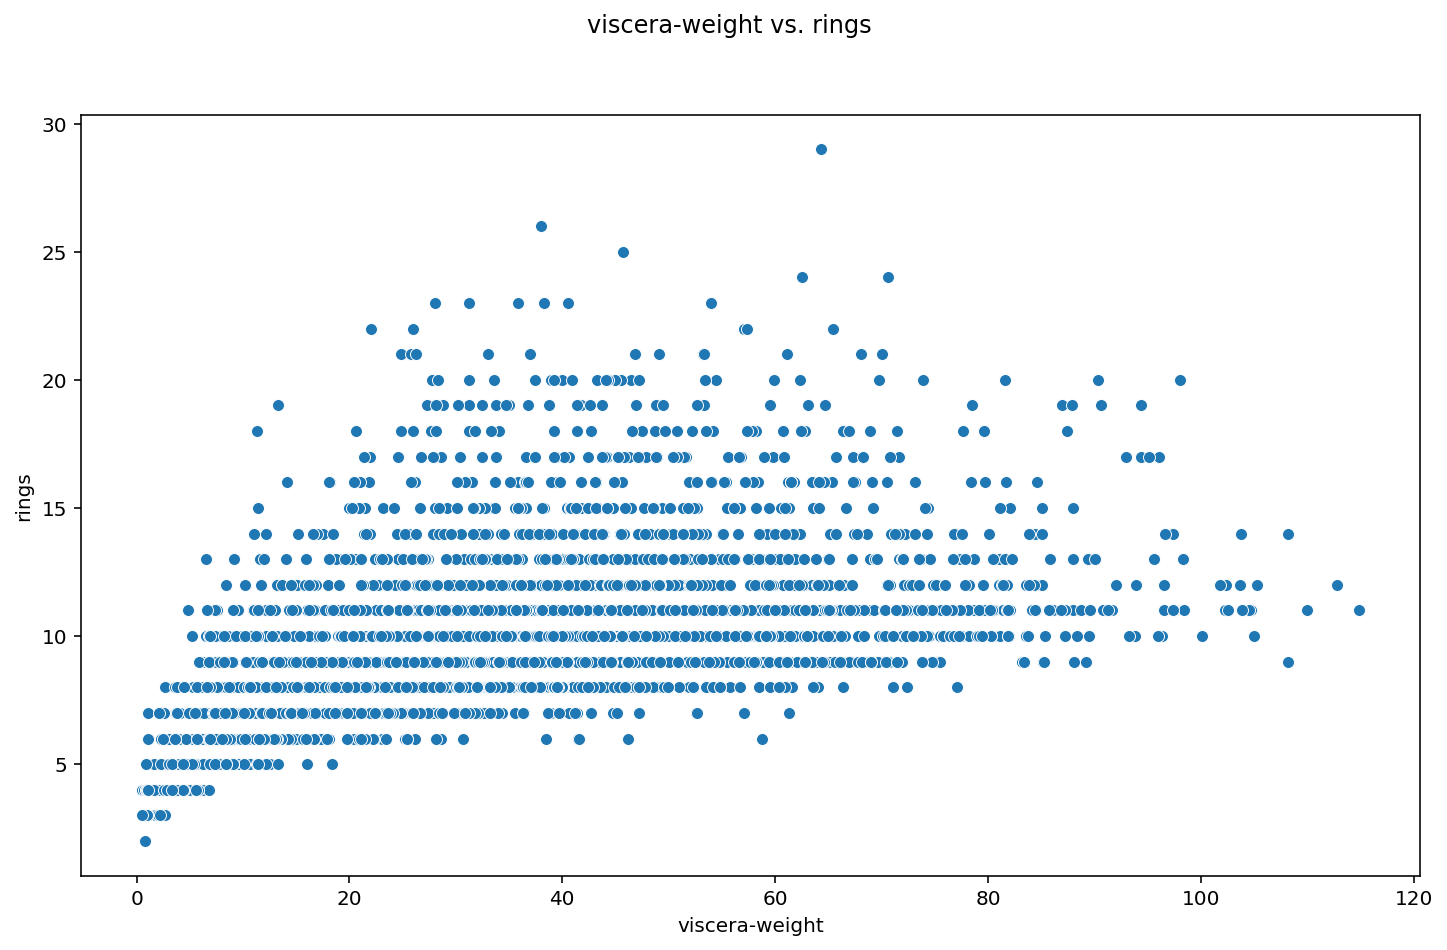

In [141]:
plot_cont_vs_target('viscera-weight')

In [142]:
train[['whole-weight', 'viscera-weight', TARGET]].corr()

,whole-weight,viscera-weight,rings
whole-weight,1.0000,0.9666,0.5420
viscera-weight,0.9666,1.0000,0.5063
rings,0.5420,0.5063,1.0000


### shell-weight

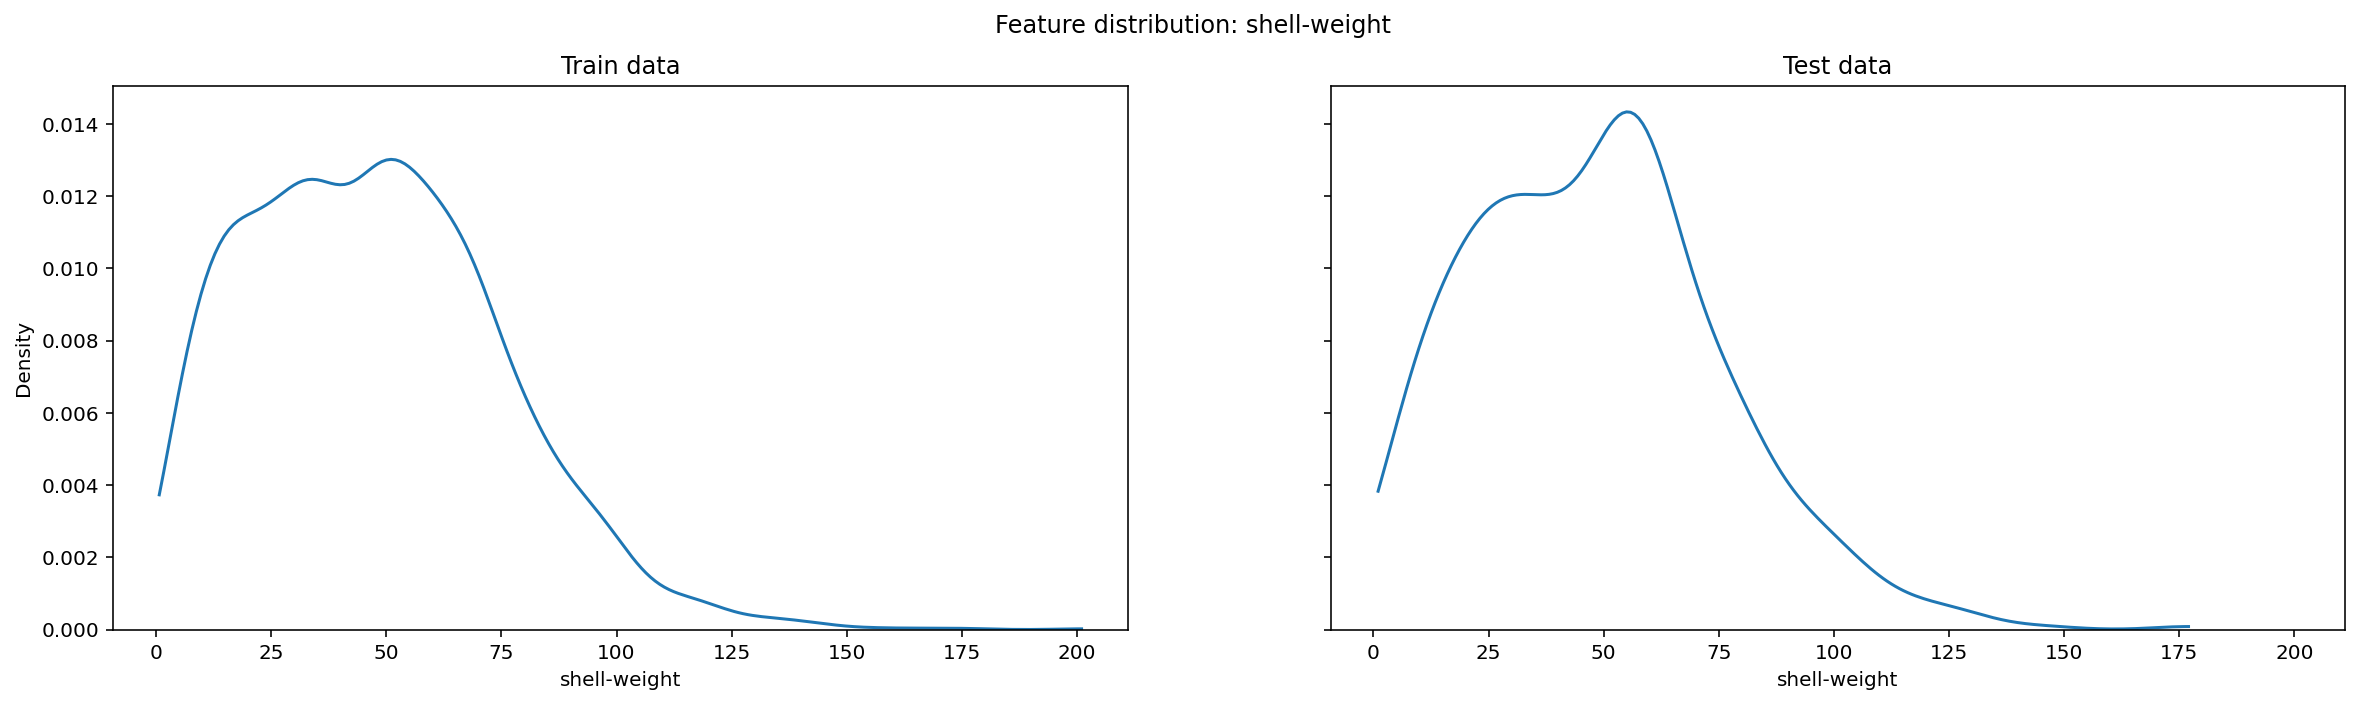

In [143]:
plot_cont('shell-weight')

In [144]:
test['shell-weight'].min(), test['shell-weight'].max()

(1.0, 177.0)

In [145]:
train.loc[train['shell-weight'] > 177]

,length,diameter,height,whole-weight,shucked-weight,viscera-weight,shell-weight,sex_F,sex_I,sex_M,rings
501,145,112,42,428.2,130.0,79.6,201.0,1,0,0,18


In [146]:
train = train[train['shell-weight'] < 200]

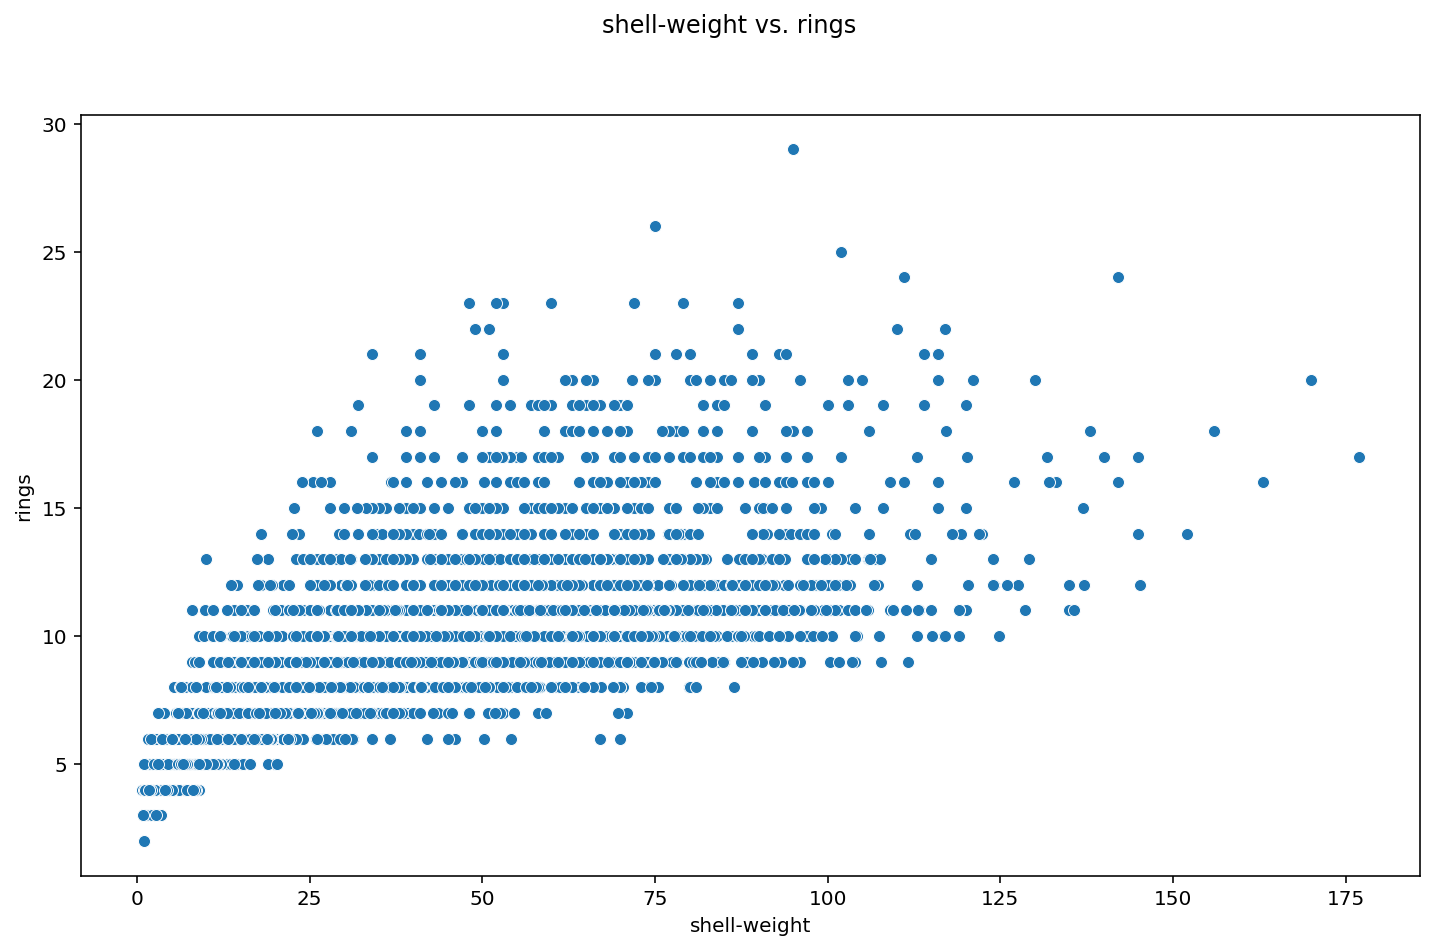

In [147]:
plot_cont_vs_target('shell-weight')

### sex_F/I/M

In [148]:
train.groupby('sex_F')[TARGET].agg(['count', 'min', 'max', 'mean', 'median'])

,count,min,max,mean,median
sex_F,,,,,
0,2445,2,26,9.3820,9.0
1,1090,5,29,11.1358,10.0


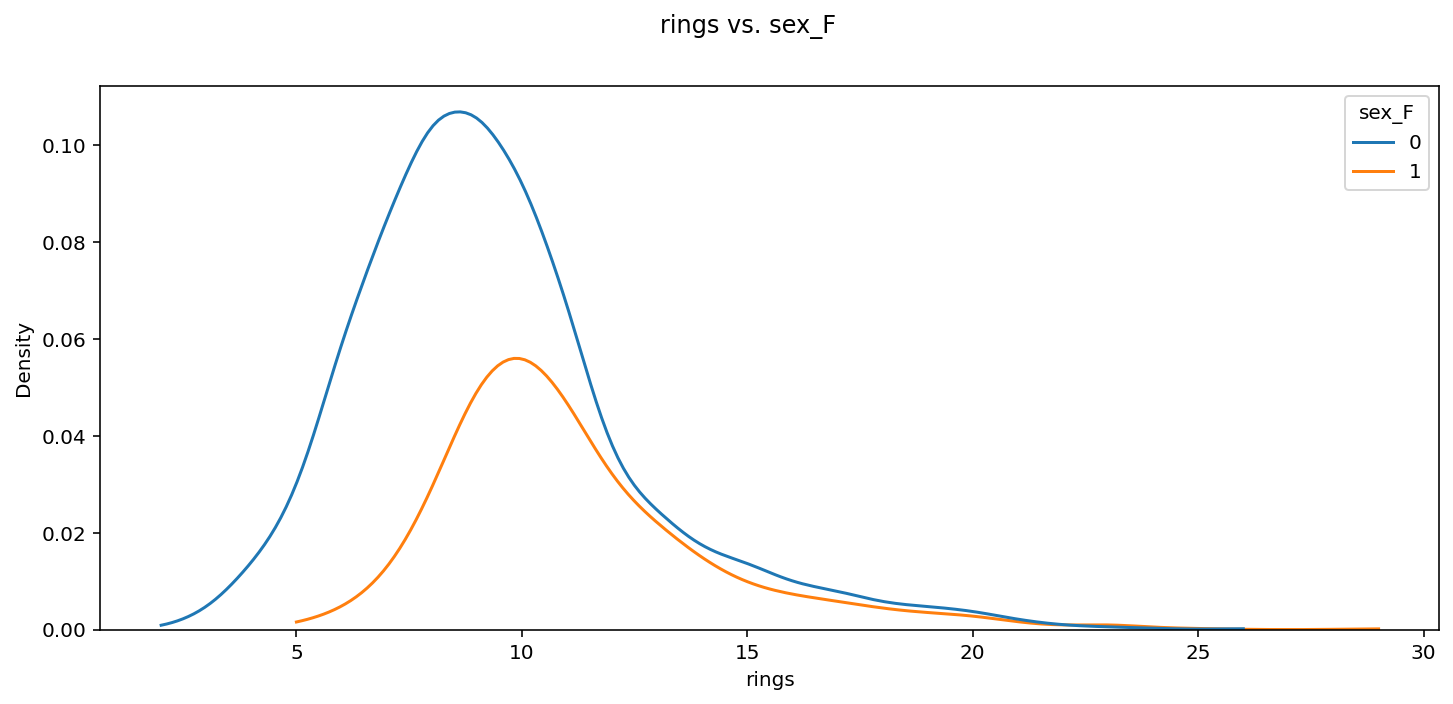

In [149]:
plot_target_vs_cat('sex_F')

In [150]:
train.groupby('sex_I')[TARGET].agg(['count', 'min', 'max', 'mean', 'median'])

,count,min,max,mean,median
sex_I,,,,,
0,2394,3,29,10.8985,10.0
1,1141,2,21,7.8755,8.0


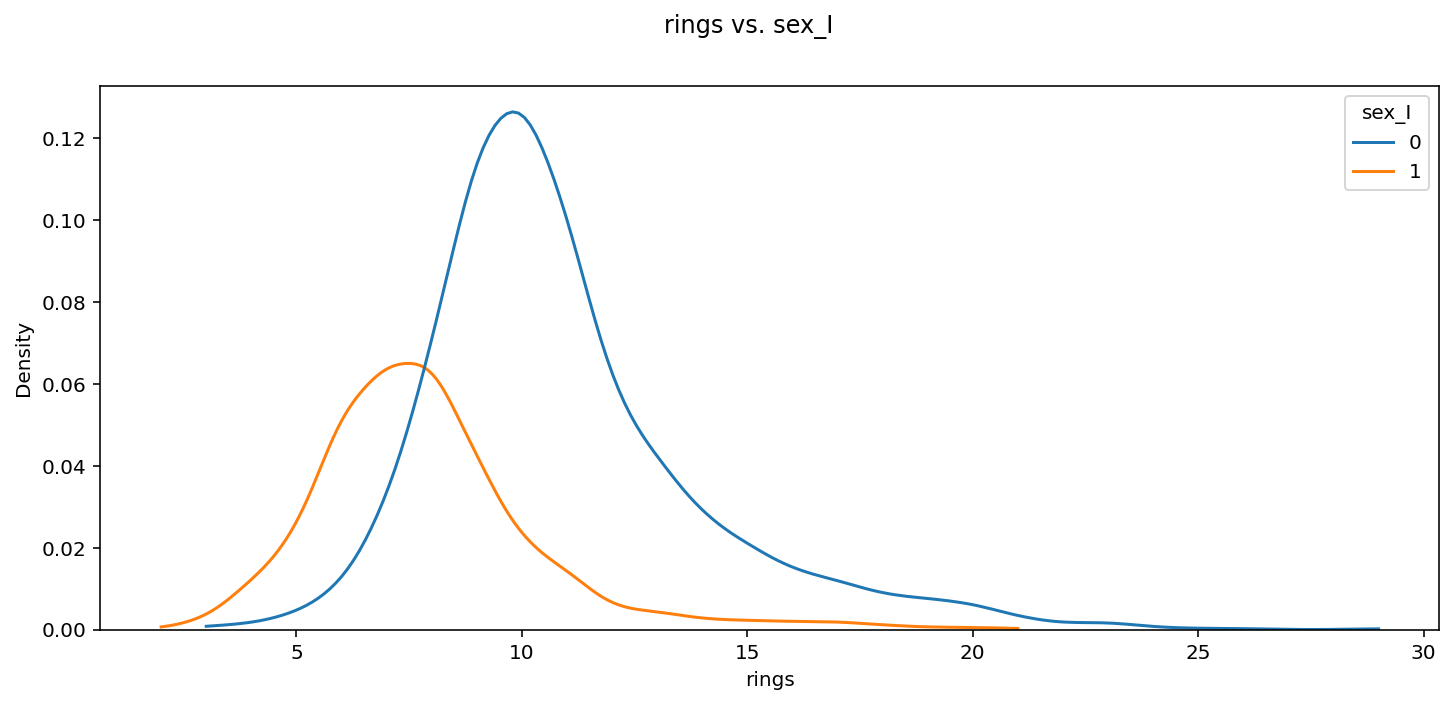

In [151]:
plot_target_vs_cat('sex_I')

In [152]:
train.groupby('sex_M')[TARGET].agg(['count', 'min', 'max', 'mean', 'median'])

,count,min,max,mean,median
sex_M,,,,,
0,2231,2,29,9.4684,9.0
1,1304,3,26,10.7002,10.0


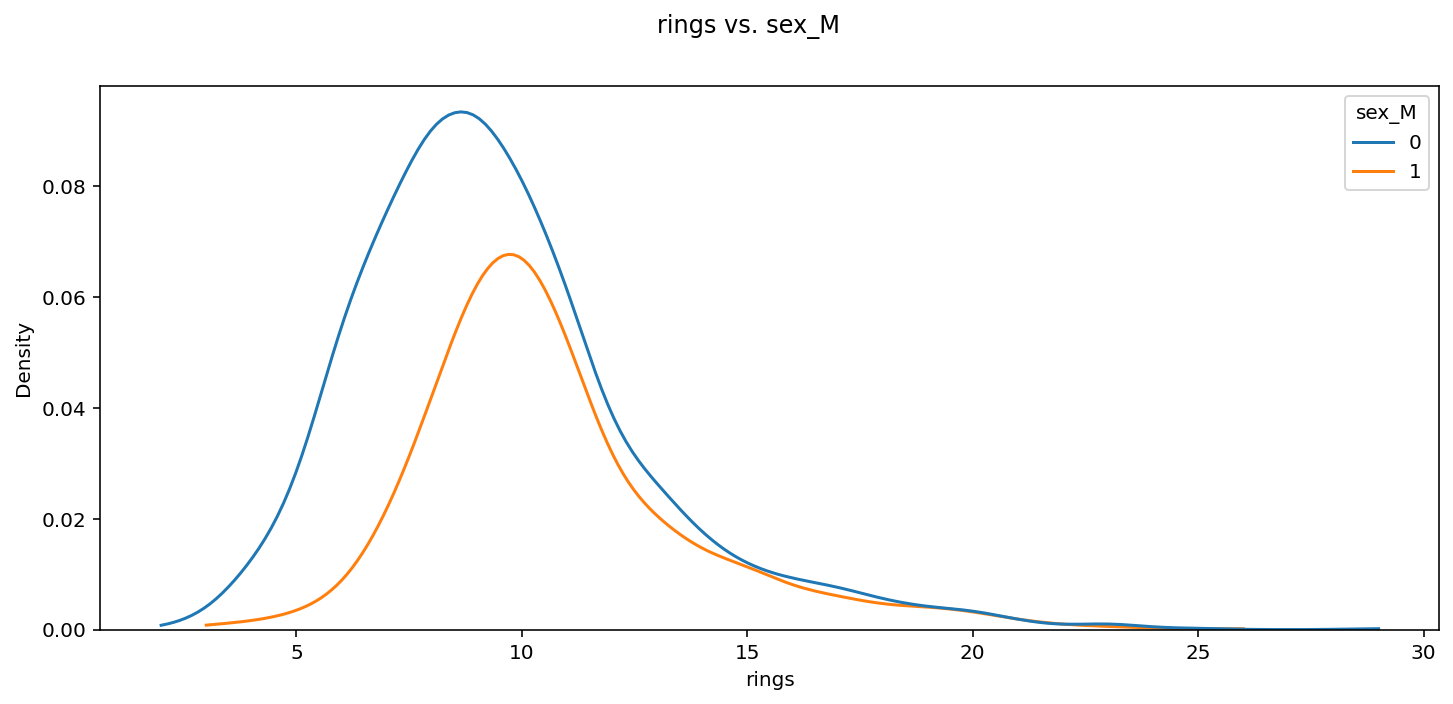

In [153]:
plot_target_vs_cat('sex_M')

* F/I/M distribution is approximately even.
* Females have the highest average rings. Infants obviously have the lowest.

In [154]:
train[['sex_F', 'sex_I', 'sex_M']] = train[['sex_F', 'sex_I', 'sex_M']].astype('int8')
test[['sex_F', 'sex_I', 'sex_M']] = test[['sex_F', 'sex_I', 'sex_M']].astype('int8')

### TARGET: rings

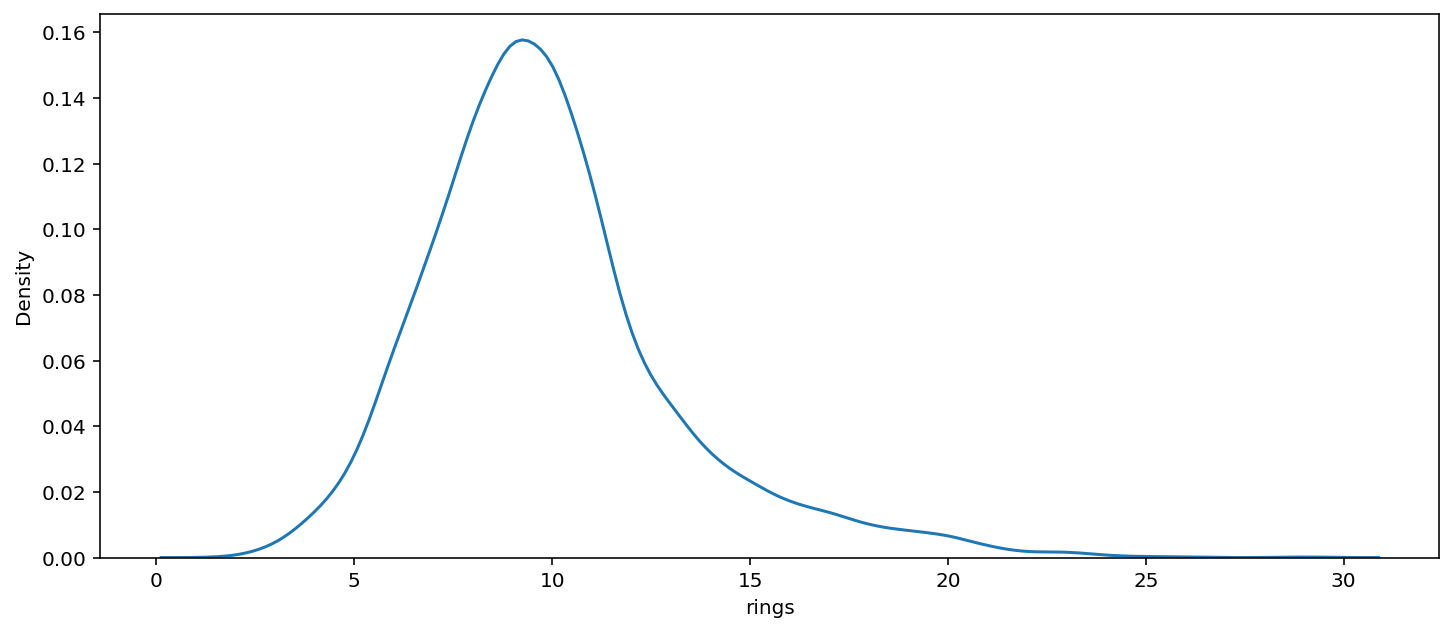

In [155]:
plt.figure(figsize=(12,5))
sns.kdeplot(x=TARGET, data=train)
plt.show()

In [156]:
len(train.loc[train[TARGET] > 20]), len(train.loc[train[TARGET] > 22]), len(train.loc[train[TARGET] >= 25]) 

(29, 12, 3)

In [157]:
train = train[train[TARGET] < 25]

# Feature selection

In [158]:
features = list(test.columns)
cat_features = ['sex_F', 'sex_I', 'sex_M']
num_features = [f for f in features if f not in cat_features]

**Correlation**

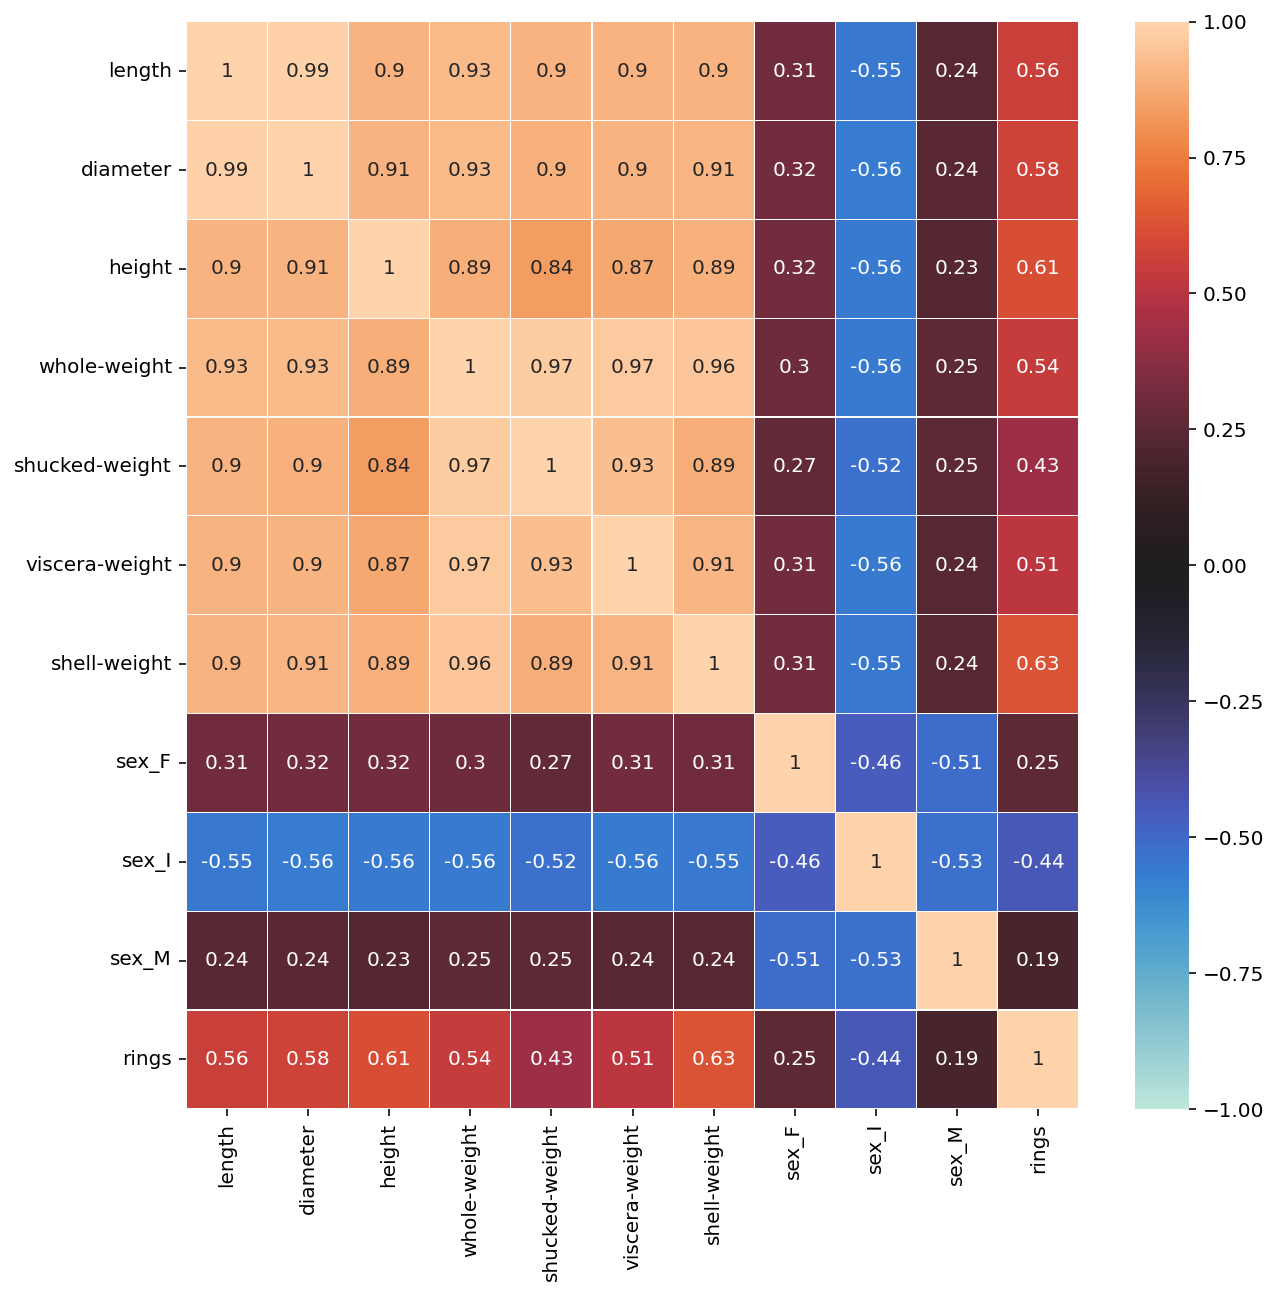

In [159]:
corr_df = train.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr_df, vmin=-1, vmax=1, center=0, annot=True, linewidths=0.1)
plt.show()

**Variance Inflation Factor**

In [160]:
%%capture
!pip install --upgrade statsmodels==0.13.2
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [161]:
def remove_vif_features(X: pd.DataFrame, threshold: float = 5.0) -> list:
    """Remove feature with highest Variance Inflation Factor
    at every iteration until all remaining features are below
    a certain threshold.
    """
    i = 0
    while X.shape[1] > 1:
        vif = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
        max_vif = np.max(vif)

        if max_vif <= threshold:
            break

        i += 1
        col_to_remove = X.columns[np.argmax(vif)]
        print(f"Iteration {i}: {col_to_remove:20} ({max_vif:.4f})")
        X.drop(col_to_remove, axis=1, inplace=True)

    if i == 0:
        print(f"No columns removed")
    else:
        print(pd.DataFrame({"Remaining features": X.columns, "VIF": vif}))

    return list(X.columns)

Checking redundant features at different thresholds (most redundant feature removed at each iteration):

In [162]:
_ = remove_vif_features(train[features].copy(), 10) #lenient threshold

Iteration 1: whole-weight         (114.5527)
Iteration 2: diameter             (42.1392)
Iteration 3: sex_M                (27.2588)
Iteration 4: height               (88.5710)
Iteration 5: viscera-weight       (39.9704)
Iteration 6: shell-weight         (22.8266)
Iteration 7: length               (15.0729)
  Remaining features     VIF
0     shucked-weight  1.7074
1              sex_F  1.5943
2              sex_I  1.1131


In [163]:
_ = remove_vif_features(train[features].copy(), 5) #rule-of-thumb threshold

Iteration 1: whole-weight         (114.5527)
Iteration 2: diameter             (42.1392)
Iteration 3: sex_M                (27.2588)
Iteration 4: height               (88.5710)
Iteration 5: viscera-weight       (39.9704)
Iteration 6: shell-weight         (22.8266)
Iteration 7: length               (15.0729)
  Remaining features     VIF
0     shucked-weight  1.7074
1              sex_F  1.5943
2              sex_I  1.1131


**Univariate linear regression test**

In [164]:
reg_test = f_regression(train[features], train[TARGET])

pd.DataFrame(
    data={
        'f-statistic': reg_test[0], 
        'p-value': reg_test[1],
        'accepted?': reg_test[1] < 0.05
    },
    index=features
).T

,length,diameter,height,whole-weight,shucked-weight,viscera-weight,shell-weight,sex_F,sex_I,sex_M
f-statistic,1592.0284,1746.4499,2107.1548,1470.1111,779.0181,1232.7238,2284.5135,238.4095,856.618,128.7898
p-value,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
accepted?,True,True,True,True,True,True,True,True,True,True


**Mutual Information score**

In [165]:
cat_mask = [(f in cat_features) for f in features] #boolean mask for discrete features

mi_scores = mutual_info_regression(train[features], train[TARGET], 
                                   discrete_features=cat_mask, 
                                   random_state=SEED)

pd.DataFrame(
    data={'mi_score': mi_scores}, 
    index=features
).T

,length,diameter,height,whole-weight,shucked-weight,viscera-weight,shell-weight,sex_F,sex_I,sex_M
mi_score,0.3759,0.3937,0.3983,0.3846,0.334,0.3922,0.4475,0.0451,0.1499,0.0217


**Feature sets**

In [166]:
feature_sets = {
    'All features': features,
    'Correlation-reduced': ['diameter', 'shell-weight', 'sex_F', 'sex_I', 'sex_M'],
    'VIF-reduced': ['shucked-weight', 'sex_F', 'sex_I'],
    'MI-reduced': [f for f in features if f not in ('sex_M', 'sex_F')]
}

# Modeling

In [167]:
scaler1 = StandardScaler()
scaler2 = MinMaxScaler()

pca1 = PCA(n_components=0.95, svd_solver='full')
pca2 = PCA(n_components='mle', svd_solver='full')

ct1 = ColumnTransformer([
    ('scaler', scaler1, make_column_selector(dtype_include=['int64', 'float64']))
], remainder='passthrough')

ct2 = ColumnTransformer([
    ('scaler', scaler2, make_column_selector(dtype_include=['int64', 'float64']))
], remainder='passthrough')

ct3 = ColumnTransformer([
    ('scaler', scaler1, make_column_selector(dtype_include=['int64', 'float64'])),
    ('pca', pca1, make_column_selector(dtype_include=['int64', 'float64']))
], remainder='passthrough')

ct4 = ColumnTransformer([
    ('scaler', scaler1, make_column_selector(dtype_include=['int64', 'float64'])),
    ('pca', pca2, make_column_selector(dtype_include=['int64', 'float64']))
], remainder='passthrough')

regressor = LinearRegression()

In [168]:
models = {
    'StandardScaler only': Pipeline([
        ('preprocessor', ct1),
        ('regressor', regressor)
    ]),

    'MinMaxScaler only': Pipeline([
        ('preprocessor', ct2),
        ('regressor', regressor)
    ]),

    'StandardScaler + PCA-95%': Pipeline([
        ('preprocessor', ct3),
        ('regressor', regressor)
    ]),

    'StandardScaler + PCA-MLE': Pipeline([
        ('preprocessor', ct4),
        ('regressor', regressor)
    ])
}

In [169]:
def evaluate_model(model, dataset, feature_set):
    preds_oof = {}
    preds_test = []
    scores_rmse = []
    
    X = dataset[0][feature_set]
    y = dataset[0][TARGET]
    X_test = dataset[1][feature_set]
    
    cv_start = time.time()
    cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        X_train, y_train = X.loc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.loc[val_idx], y.iloc[val_idx]
        
        fold_start = time.time()
        
        model.fit(X_train, y_train)
        preds_val = model.predict(X_val)
        preds_oof.update(dict(zip(val_idx, preds_val)))
        score = mean_squared_error(y_val, preds_val, squared=False)
        scores_rmse.append(score)
        preds_test.append(model.predict(X_test))

        fold_end = time.time()
        print(f'Fold-{fold}: {score:.4f}', end=' | ')
        _ = gc.collect()
    
    cv_end = time.time()
    print(f'AVG = {np.mean(scores_rmse):.4f} +/- {np.std(scores_rmse):.4f} ' \
          f'[Total time: {cv_end - cv_start:.2f}s]')
    
    preds_oof = np.asarray(list(dict(sorted(preds_oof.items())).values()))
    preds_test = np.mean(np.column_stack(preds_test), axis=1)
    return preds_oof, preds_test


In [170]:
train_orig = pd.read_csv(data_url + 'raw/train.csv')
test_orig = pd.read_csv(data_url + 'raw/test.csv')

train = train.reset_index()

In [171]:
datasets = {
    'Original dataset': (train_orig, test_orig),
    'Outliers clipped dataset': (train, test)
}

In [172]:
oof_dict = {}
preds_dict = {}

In [173]:
%%time

i = 0
for dataset_name in datasets:
    for feature_set_name in feature_sets:
        for model_name in models:
            print(f'\n[#{i}] Dataset: {dataset_name},' \
                  f'Feature set: {feature_set_name}, '\
                  f'Model: {model_name}', 
                  end='\n| ')
            
            oof_dict[i], preds_dict[i] = evaluate_model(models[model_name], 
                                                        datasets[dataset_name],
                                                        feature_sets[feature_set_name])
            print('-' * 120)
            i += 1


[#0] Dataset: Original dataset,Feature set: All features, Model: StandardScaler only
| Fold-0: 2.2869 | Fold-1: 2.1586 | Fold-2: 2.2260 | Fold-3: 2.1094 | Fold-4: 2.2808 | AVG = 2.2123 +/- 0.0691 [Total time: 0.76s]
------------------------------------------------------------------------------------------------------------------------

[#1] Dataset: Original dataset,Feature set: All features, Model: MinMaxScaler only
| Fold-0: 2.2868 | Fold-1: 2.1586 | Fold-2: 2.2257 | Fold-3: 2.1094 | Fold-4: 2.2869 | AVG = 2.2135 +/- 0.0704 [Total time: 0.69s]
------------------------------------------------------------------------------------------------------------------------

[#2] Dataset: Original dataset,Feature set: All features, Model: StandardScaler + PCA-95%
| Fold-0: 2.2869 | Fold-1: 2.1586 | Fold-2: 2.2260 | Fold-3: 2.1094 | Fold-4: 2.2869 | AVG = 2.2136 +/- 0.0704 [Total time: 0.70s]
--------------------------------------------------------------------------------------------------------

# Postprocessing

In [174]:
preds_dict[16][:10]

array([10.7117,  7.2897,  6.7747, 10.2095, 10.4924, 14.0262, 13.3628,
        9.1305,  9.8569,  9.9776])

In the dataset, target values are integers. We can use these predictions as-is, or round them to the nearest integer to conform with the original data.

In [175]:
np.round(preds_dict[16][:10])

array([11.,  7.,  7., 10., 10., 14., 13.,  9., 10., 10.])

In [176]:
pp_preds_dict = {} #postprocessed preds
pp_oof_dict = {}

for i in preds_dict:
    pp_preds_dict[i] = np.round(preds_dict[i])
    pp_oof_dict[i] = np.round(oof_dict[i])

**Original dataset**

In [179]:
pd.DataFrame(
    data={
        'Raw': [mean_squared_error(train_orig[TARGET], oof_dict[i], squared=False) 
                for i in range(16)],
        'Postprocessed': [mean_squared_error(train_orig[TARGET], pp_oof_dict[i], squared=False) 
                          for i in range(16)]
    },
    index=range(16)
)

,Raw,Postprocessed
0,2.2134,2.2367
1,2.2146,2.2404
2,2.2147,2.2392
3,2.2147,2.2392
4,2.4880,2.4979
5,2.4900,2.5040
6,2.4882,2.5028
7,2.4882,2.5028
8,2.8013,2.8106
9,2.8013,2.8106


**Outliers clipped dataset**

In [180]:
pd.DataFrame(
    data={
        'Raw': [mean_squared_error(train[TARGET], oof_dict[i], squared=False) 
                for i in range(16, 32)],
        'Postprocessed': [mean_squared_error(train[TARGET], pp_oof_dict[i], squared=False) 
                          for i in range(16, 32)]
    },
    index=range(16, 32)
)

,Raw,Postprocessed
16,2.1596,2.1831
17,2.1600,2.1847
18,2.1596,2.1831
19,2.1596,2.1831
20,2.4503,2.4708
21,2.4505,2.4723
22,2.4503,2.4708
23,2.4503,2.4708
24,2.7564,2.7641
25,2.7564,2.7641


Looks like raw predictions are better in every case.

# Generating submission files

In [181]:
submissions_root = '/content/drive/MyDrive/data_science_competitions/dphi/ds88/submissions/'
submission_path = f'{submissions_root}/01' #for notebook 01

if not os.path.isdir(submission_path):
    os.mkdir(submission_path)
    
for i, preds in preds_dict.items():
    sub_df = pd.DataFrame({
        'rings': preds
    })
    sub_df.to_csv(f'{submission_path}/sub_{i}.csv', index=False)
    _ = gc.collect()